# Read Before

- https://www.kaggle.com/code/raddar/icr-competition-analysis-and-findings/notebook
- https://www.tensorflow.org/guide/core/logistic_regression_core
- https://www.kaggle.com/code/muelsamu/simple-tabpfn-approach-for-score-of-15-in-1-min/notebook - good example how to add TabPFN
- https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Metric - good guide on creating custom metric in Keras
- https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/410139 - overall notes about similar competitions

Plan:
- [x] Feature Engineering (1 day)
- [x] CV and Model Selection (1 day)
- [x] Validation (1 day)
- [x] Review
- [x] Make Artefacts -> Made Utility script for WoE
- [x] Solve Error With Solution -> Made If new catgory then choose worst WoEs (Can make two splits woth worst and other value )
- [x] Add TabPFN (Added Private Sample with package files) and No CV TabPFN preds
- [x] Added Weighted Submition with respect to Competion Metric Mean
- [x] Refactor More Accurately train RF part & Make Dev branch for Git
- [x] Experiment with GadientClassifier and Parameters ( Tried GadientClassifier / Added Better displayed TOC )
- [x] CV TabPFN - looks even inferior to GBT. May be due to preprosessing.
- [x] Ensembled into Submition results from several Classifiers (There is aa room for Playing with manually assigned weights)
- [x] Due to time consideration -> SUBMITION: bool
- [x] Submition Error When calculating results.
- [x] Rethink CV (check dimension) v31->v32,
- [x] Solve problem with accuracy (showns NaNs) -> Changed to Binary Accuracy version
- [x] Solved problem with NaNs in metric -> min/max vals less than 1 more than 0, as in competrion calculator
- [ ] loss: 0.0000e+00. Why ? Is it OK ? -> Yes it is okey. https://discuss.tensorflow.org/t/tfdf-custom-loss/2223
- [ ] Research wheather it is possible to train with respect to Gradient of the metric.
- [ ] Found that some variables are constant as they represent some features for categroical column which takes only two values, so makes sense to drop them in order not overtrain. I will make split -> make two versions of model which is run if Group A (on all data), which is Group B ( which finetuned after )
- [ ] Ensemble Results by some model:
    - Currently Simple Manual Weights, which may be more optimal. Need to make some grid and choose the best.
    - I use Mean for Each CV Branch, may-be also grant some threshs or weights
    - [x] Refactored each Model Estimation to result into Train/Valid/Test Frames

In [1]:
SUBMITION = False

## Install TabPFN offline

In [2]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr

!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff

!cp /kaggle/input/pip-packages-icr/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file:///kaggle/input/pip-packages-icr
Processing /kaggle/input/pip-packages-icr/tabpfn-0.1.9-py3-none-any.whl


# Import Utils

In [3]:
from woe_utils import WOENumericalComplex

# Import Standard Libs

In [4]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from keras import metrics # accuracy
from keras import backend as K

import keras_tuner as kt

import pandas as pd
from pandas.api.types import is_numeric_dtype

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedKFold, KFold

from tabpfn import TabPFNClassifier

import warnings
from tqdm.notebook import tqdm

pd.set_option('display.max_rows', 500)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Load the Dataset

In [5]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv', index_col='Id')
dataset_df.columns = dataset_df.columns.str.rstrip()
print("Full train dataset shape is {}".format(dataset_df.shape))

dataset_test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv', index_col='Id')
dataset_test_df.columns = dataset_test_df.columns.str.rstrip()
print("Full test dataset shape is {}".format(dataset_test_df.shape))

Full train dataset shape is (617, 57)
Full test dataset shape is (5, 56)


# Compute Basic Info

In [6]:
def compute_basic_stats(columns, df):
    out = {}
    
    for i in tqdm(columns):
        mask = df[i].notna()
        
        out[i] = {'nunique':df[i].nunique(),
                  'na_share':round(100*df[i].isna().sum()/df[i].count(),1),
                  'dtype':df[i].dtype
                 }
        if is_numeric_dtype(df[i]):
            out[i]['correlation'] = round(np.corrcoef(x=df.loc[mask,i],y=df.loc[mask,'Class'])[0,1],2)
            out[i]['min'] = df.loc[mask,i].min()
            out[i]['max'] = df.loc[mask,i].max()
            out[i]['std'] = df.loc[mask,i].std()
            out[i]['mean'] = df.loc[mask,i].mean()
            i_lorreg = LogisticRegression()
            X = df.loc[mask,i].values.reshape(-1,1)
            y = df.loc[mask,'Class'].values
            i_lorreg.fit(X=X, y=y)
            y_pred = i_lorreg.predict(X)
            out[i]['logloss'] = log_loss(y_true=y, y_pred=y_pred)
            
            
    out = pd.DataFrame(out).T
    
    out = out.sort_values('logloss',ascending=True)
    
    return out

basic_stats_1 = compute_basic_stats(
    columns=[i for i in dataset_df.columns if i not in ["Id","Class"]],         
    df=dataset_df)

  0%|          | 0/56 [00:00<?, ?it/s]

* Only one variable looks constrant over the target -> better to omit it.
* Realised Better to add LogLoss metric for each feature -> loggloss


# Create Features

In [7]:
def preprocess(train: pd.DataFrame, test: pd.DataFrame, stats: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, dict):
    info = dict()
    woes = dict()
    numeric_features = stats[stats.logloss.notna()].index.tolist() # Cause for EJ logloss is null
    train_out = train.copy()
    test_out = test.copy()
    
    out_features = list()
    
    # Make WoE Columns
    for i in tqdm(numeric_features, 'WoE Encoding: '):
        tmp_woe = WOENumericalComplex()
        tmp_woe.fit(x=train_out[i], y=train_out['Class'])
        train_out[i + '_WoE'] = tmp_woe.transform(X=train_out[i])
        test_out[i + '_WoE'] = tmp_woe.transform(X=test_out[i])
        out_features.append(i + '_WoE')
        woes[i] = tmp_woe
    
    
    # Make NA columns
    for i in tqdm(['DU', 'FC', 'FS', 'CC', 'FL', 'GL', 'CB', 'EL', 'BQ'], 'Split by NA: '):
        train_out[i+'_na'] = np.where(train_out[i].isna(),1,0)
        test_out[i+'_na'] = np.where(test_out[i].isna(),1,0)
        out_features.append(i + '_na')
    
    # Basic Logic -> normalise
    for i in tqdm(numeric_features,'Normalise Numeric: '):
        if stats.loc[i,'correlation'] > 0:
            na_value = stats.loc[i,'max']
        else:
            na_value = stats.loc[i,'min']

        train_out[i] = train_out[i].fillna(na_value)
        test_out[i] = test_out[i].fillna(na_value)

        train_out[i] = (train_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']
        test_out[i] = (test_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']

        out_features.append(i)
            
            
    # Addition EJ -> has only two values, so if EJ == 'A'
    train_out['EJ' + '_A'] = np.where(train_out['EJ'] == 'A',1,0)
    test_out['EJ' + '_A'] = np.where(test_out['EJ'] == 'A',1,0)
    out_features.append('EJ' + '_A')
    
    return train_out,test_out,out_features, woes


train_out,test_out,features, woes = preprocess(train=dataset_df, test=dataset_test_df, stats=basic_stats_1)

WoE Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

Split by NA:   0%|          | 0/9 [00:00<?, ?it/s]

Normalise Numeric:   0%|          | 0/55 [00:00<?, ?it/s]

In [8]:
basic_stats_2 = compute_basic_stats(
    columns=[i for i in train_out.columns if i not in ["Id","Class"]],         
    df=train_out)

basic_stats_2

  0%|          | 0/121 [00:00<?, ?it/s]

,nunique,na_share,dtype,correlation,min,max,std,mean,logloss
DU_WoE,4,0.0,float64,-0.52,-2.678782,2.977892,1.042059,0.286027,4.790242
FL_WoE,4,0.0,float64,-0.42,-2.045013,2.977892,0.86161,0.214552,5.374418
DI_WoE,3,0.0,float64,-0.37,-2.361247,0.382521,0.698812,0.124925,5.432836
DA_WoE,3,0.0,float64,-0.37,-2.093932,0.463416,0.719046,0.14452,5.549671
GL_WoE,4,0.0,float64,-0.4,-1.805209,2.977892,0.865805,0.230269,5.783341
FD_WoE,3,0.0,float64,-0.33,-1.996604,0.379845,0.635814,0.115675,5.783341
EH_WoE,3,0.0,float64,-0.32,-2.061142,0.343225,0.622624,0.111704,5.841759
EH,127,0.0,float64,0.18,-0.1635,22.876681,1.0,-0.0,5.900177
AM,605,0.0,float64,0.24,-0.513293,8.483647,1.0,0.0,5.900177
BC_WoE,3,0.0,float64,-0.3,-1.9811,0.486565,0.630381,0.116679,5.900177


# Train Model

Today, we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.
We will train a model for each fold and after training we will store the model and metrics. Here, we have chosen `accuracy` and `binary_crossentropy` as the metrics.

In [9]:

class BalancedLogLoss(tf.keras.metrics.Metric):
    def __init__(self, name='balanced_log_loss', **kwargs):
        super(BalancedLogLoss, self).__init__(name=name, **kwargs)
        self.log_loss = self.add_weight(name='log_loss', initializer='zeros')

    def update_state(self, y_true: tf.Tensor, y_pred: tf.Tensor, sample_weight=None):
        
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Correct Values
        min_val = 1e-15
        max_val = 0.999999999999999
        
        y_pred = tf.math.minimum(y_pred, [max_val])
        y_pred = tf.math.maximum(y_pred, [min_val])
        
        log_y_pred_1 = tf.reshape(K.log(y_pred),[-1,1])
        log_y_pred_0 = tf.reshape(K.log(1-y_pred),[-1,1])

        y_1 = tf.reshape(y_true,[1,-1])
        y_0 = 1-y_1

        logloss_1 = -K.dot(y_1,log_y_pred_1)[0][0]/K.sum(y_1)
        logloss_0 = -K.dot(y_0,log_y_pred_0)[0][0]/K.sum(y_0)

        av_logloss = (logloss_1+logloss_0)/2
        
        self.log_loss.assign_add(av_logloss)

    def result(self):
        return self.log_loss

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.log_loss.assign(0.)

def plot_train_logs(model) -> None:

    logs = model.make_inspector().training_logs()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")

    plt.show()

def train_model(train: pd.DataFrame, test: pd.DataFrame, features: list, label = "Class",
                n_splits: int = 6,
                model_obj = tfdf.keras.RandomForestModel,
                model_kwargs = dict(),
                model_compile_kwargs = dict()) -> (pd.DataFrame, pd.DataFrame, dict,  dict):

    # Create a various frames
    train_summary = pd.DataFrame(data=np.full((len(train.index),n_splits), np.nan), index=train.index) # For In-Sample Predictions of each Fold
    
    valid_summary = pd.DataFrame(data=np.full((len(train.index),1), np.nan), index=train.index) # For Out-of-Sample Prediction of each Fold
    
    test_tf = tfdf.keras.pd_dataframe_to_tf_dataset(test) # Technial, to conert frame to tensor for makind a predictions using tensor framework
    test_summary = pd.DataFrame(data=np.full((len(test.index),n_splits), np.nan),index=test.index) # For Test (Sumbition) Predictions of each Fold's Model
    
    # Create an empty dictionary to store the models trained for each fold.
    models = {}
    metrics = {}
    balanced_logloss_train = {}
    balanced_logloss_val = {}
    
    # Calculate the number of samples for each label.
    neg, pos = np.bincount(train[label])
    total = neg + pos
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}

    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))
    
    skf = StratifiedKFold(n_splits=n_splits)
    
    for i, (train_index, valid_index) in enumerate(skf.split(X=train,y=train['Class'])):
            print('##### Fold',i+1)

            # Fetch values corresponding to the index 
            train_df = train.iloc[train_index]
            valid_df = train.iloc[valid_index]
            valid_ids = valid_df.index.values
            train_ids = train_df.index.values

            # Select only feature columns for training.
            train_df = train_df[features+[label]]
            valid_df = valid_df[features+[label]]

            # We need to convert the datatset from Pandas format (pd.DataFrame)
            train_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
            valid_tf = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

            # Define & Train the model and metrics
            model = model_obj(**model_kwargs)
            model.compile(**model_compile_kwargs) 
            model.fit(x=train_tf, class_weight=class_weight)

            # Store the model
            models[f"fold_{i+1}"] = model

            # Predict Values
            train_summary.loc[train_ids, i] = model.predict(x=train_tf).flatten()
            valid_summary.loc[valid_ids, 0] = model.predict(x=valid_tf).flatten()
            test_summary[i] = model.predict(x=test_tf).flatten() 

            # Evaluate and store the metrics in respective dicts
            evaluation = model.evaluate(x=train_tf,return_dict=True)
            train_metric = evaluation["balanced_log_loss"]
            
            evaluation = model.evaluate(x=valid_tf,return_dict=True)
            val_metric = evaluation["balanced_log_loss"]
            
            # Plot Results
            plot_train_logs(model)
            
            balanced_logloss_train[f"fold_{i+1}"] = train_metric
            balanced_logloss_val[f"fold_{i+1}"] = val_metric
            
            print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")
    
    metrics['train'] = balanced_logloss_train
    metrics['val'] = balanced_logloss_val

    print(f"\nTrain mean: {pd.Series(balanced_logloss_train).mean():.4f} std: {pd.Series(balanced_logloss_train).std():.4f}")
    print(f"\nValidation mean: {pd.Series(balanced_logloss_val).mean():.4f} std: {pd.Series(balanced_logloss_val).std():.4f}")
         
    return train_summary, valid_summary, test_summary, models, metrics

# RandomForestModel

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmp98wwq9wc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:06.668551. Found 514 examples.
Training model...
Model trained in 0:00:00.485283
Compiling model...


[INFO 23-07-21 14:44:30.2549 UTC kernel.cc:1242] Loading model from path /tmp/tmp98wwq9wc/model/ with prefix 93903bc5032f4077
[INFO 23-07-21 14:44:30.3102 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 32956 node(s), and 114 input feature(s).
[INFO 23-07-21 14:44:30.3105 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 14:44:30.3107 UTC kernel.cc:1074] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
1/1 [==============================] - 0s 294ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9612 - balanced_log_loss: 0.3083


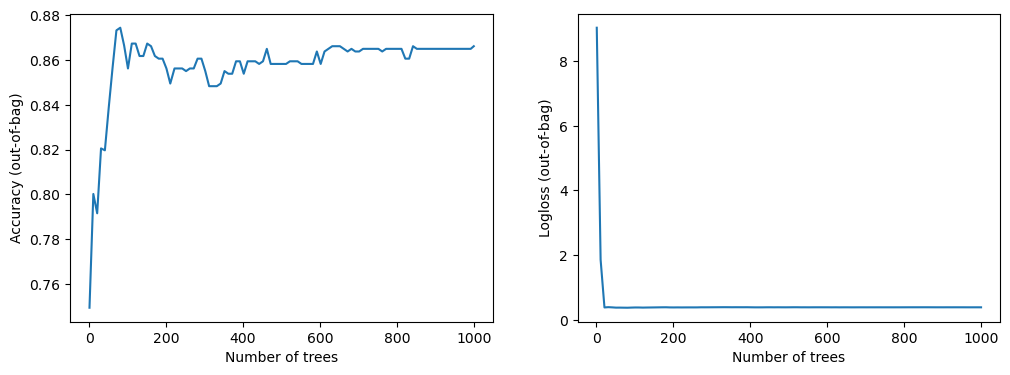


Train: 0.1878 Validation: 0.3083
##### Fold 2
Use /tmp/tmp2bo26twa as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.586120. Found 514 examples.
Training model...
Model trained in 0:00:00.450639
Compiling model...


[INFO 23-07-21 14:44:38.2301 UTC kernel.cc:1242] Loading model from path /tmp/tmp2bo26twa/model/ with prefix 99ca00be122c4c75
[INFO 23-07-21 14:44:38.2823 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 32686 node(s), and 113 input feature(s).
[INFO 23-07-21 14:44:38.2824 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 272ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8447 - balanced_log_loss: 0.4080


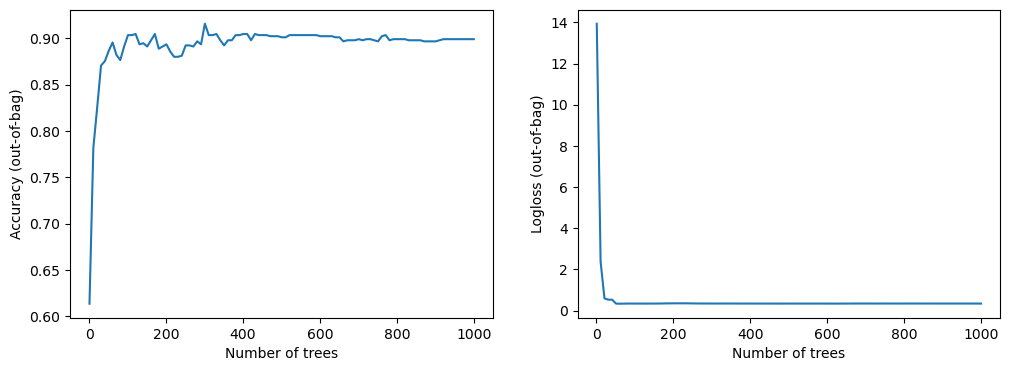


Train: 0.4765 Validation: 0.4080
##### Fold 3
Use /tmp/tmptihf3u_3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.581855. Found 514 examples.
Training model...
Model trained in 0:00:00.463540
Compiling model...


[INFO 23-07-21 14:44:43.7255 UTC kernel.cc:1242] Loading model from path /tmp/tmptihf3u_3/model/ with prefix 2b7b6acdae38463b
[INFO 23-07-21 14:44:43.7815 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33890 node(s), and 113 input feature(s).
[INFO 23-07-21 14:44:43.7816 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 14:44:43.7816 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 279ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9320 - balanced_log_loss: 0.3164


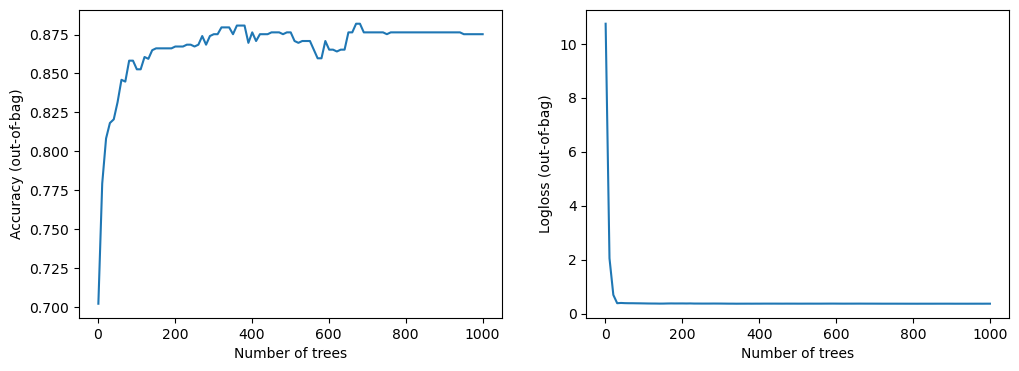


Train: 0.5861 Validation: 0.3164
##### Fold 4
Use /tmp/tmpfz1i6pe1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.516523. Found 514 examples.
Training model...
Model trained in 0:00:00.454126
Compiling model...


[INFO 23-07-21 14:44:49.0647 UTC kernel.cc:1242] Loading model from path /tmp/tmpfz1i6pe1/model/ with prefix 0c6091ab84e64a6b
[INFO 23-07-21 14:44:49.1182 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33338 node(s), and 112 input feature(s).
[INFO 23-07-21 14:44:49.1184 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 288ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9223 - balanced_log_loss: 0.3642


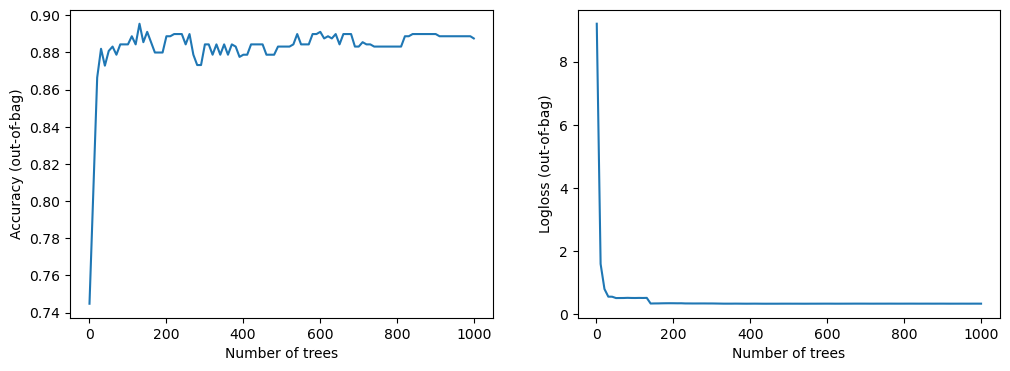


Train: 0.4843 Validation: 0.3642
##### Fold 5
Use /tmp/tmp8xr8pruy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.472082. Found 514 examples.
Training model...
Model trained in 0:00:00.433972
Compiling model...


[INFO 23-07-21 14:44:54.3446 UTC kernel.cc:1242] Loading model from path /tmp/tmp8xr8pruy/model/ with prefix d8f293ad2eb643cb
[INFO 23-07-21 14:44:54.4021 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 32930 node(s), and 113 input feature(s).
[INFO 23-07-21 14:44:54.4021 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 14:44:54.4022 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 276ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9320 - balanced_log_loss: 0.4281


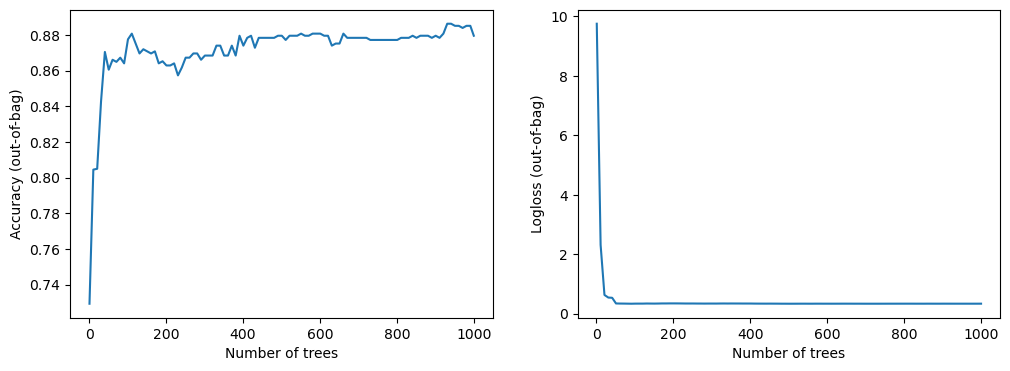


Train: 0.5298 Validation: 0.4281
##### Fold 6
Use /tmp/tmpjipn37o4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.513446. Found 515 examples.
Training model...
Model trained in 0:00:00.432327
Compiling model...


[INFO 23-07-21 14:45:00.0814 UTC kernel.cc:1242] Loading model from path /tmp/tmpjipn37o4/model/ with prefix 9e04eca1c7ec4573
[INFO 23-07-21 14:45:00.1358 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33646 node(s), and 113 input feature(s).
[INFO 23-07-21 14:45:00.1358 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 286ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9706 - balanced_log_loss: 0.2618


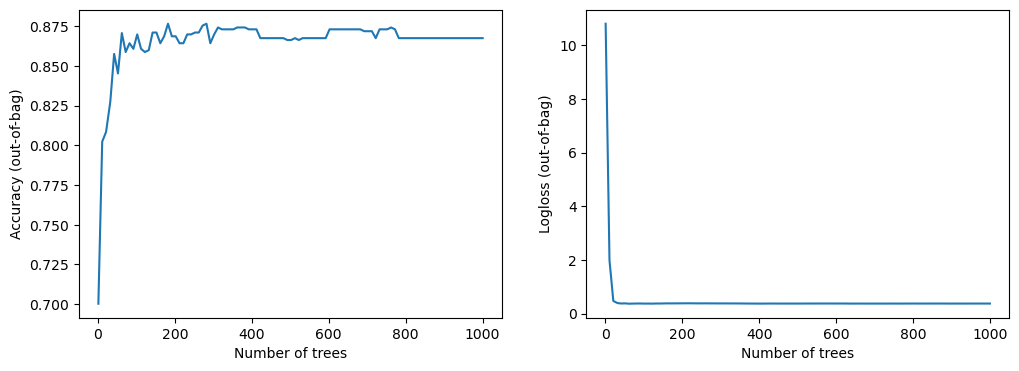


Train: 0.6131 Validation: 0.2618

Train mean: 0.4796 std: 0.1529

Validation mean: 0.3478 std: 0.0637


In [10]:
# RandomForestModel
if not SUBMITION:
    train_summary_rf_1, valid_summary_rf_1, test_summary_rf_1, model_rf_1,metrics_rf_1 = train_model(
        train=train_out,test=test_out, features=features,
        n_splits=6,
        model_obj=tfdf.keras.RandomForestModel,
        model_kwargs=dict(max_depth=6, num_trees=1000),
        model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmp9legxj03 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.565055. Found 555 examples.
Training model...
Model trained in 0:00:00.149507
Compiling model...


[INFO 23-07-21 14:45:06.6286 UTC kernel.cc:1242] Loading model from path /tmp/tmp9legxj03/model/ with prefix 4b4b77bbc1754bf7
[INFO 23-07-21 14:45:06.6448 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10190 node(s), and 112 input feature(s).
[INFO 23-07-21 14:45:06.6449 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 14:45:06.6449 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 297ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.3015


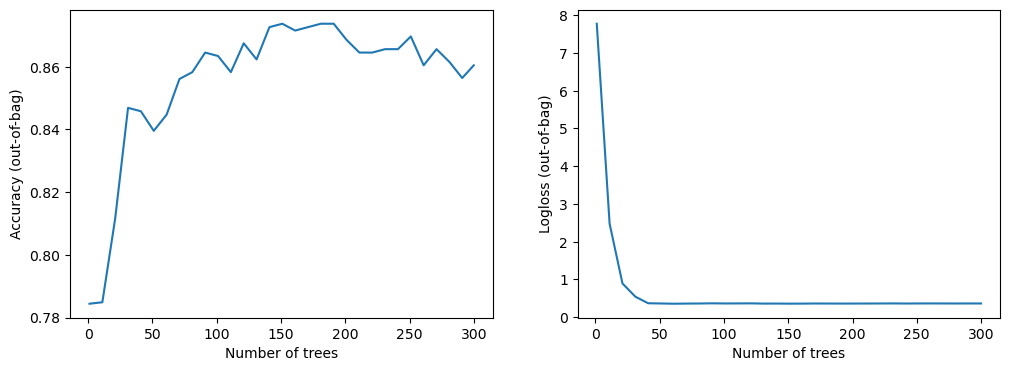


Train: 0.1855 Validation: 0.3015
##### Fold 2
Use /tmp/tmpymmabyum as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.641021. Found 555 examples.
Training model...
Model trained in 0:00:00.149116
Compiling model...


[INFO 23-07-21 14:45:11.8677 UTC kernel.cc:1242] Loading model from path /tmp/tmpymmabyum/model/ with prefix 179493a1ea534e61
[INFO 23-07-21 14:45:11.8837 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10330 node(s), and 113 input feature(s).
[INFO 23-07-21 14:45:11.8838 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 271ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.3116


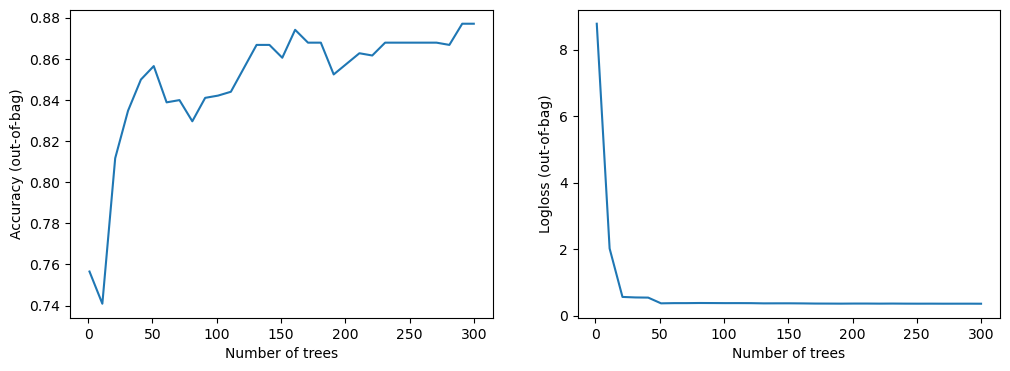


Train: 0.4840 Validation: 0.3116
##### Fold 3
Use /tmp/tmpn_p6zxl6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.502684. Found 555 examples.
Training model...
Model trained in 0:00:00.153752
Compiling model...


[INFO 23-07-21 14:45:16.9566 UTC kernel.cc:1242] Loading model from path /tmp/tmpn_p6zxl6/model/ with prefix 30a046ceee514567
[INFO 23-07-21 14:45:16.9744 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10300 node(s), and 112 input feature(s).
[INFO 23-07-21 14:45:16.9744 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 14:45:16.9744 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 284ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8548 - balanced_log_loss: 0.4417


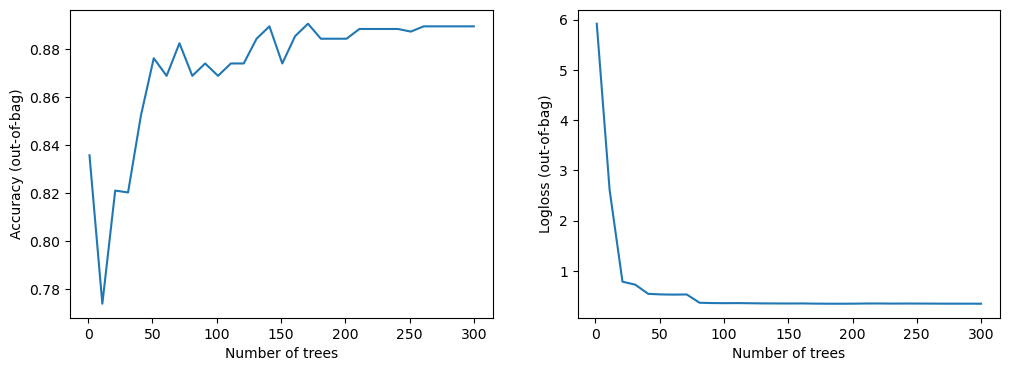


Train: 0.4848 Validation: 0.4417
##### Fold 4
Use /tmp/tmpr92496w7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.576418. Found 555 examples.
Training model...
Model trained in 0:00:00.158917
Compiling model...


[INFO 23-07-21 14:45:22.1055 UTC kernel.cc:1242] Loading model from path /tmp/tmpr92496w7/model/ with prefix 456b7b977f184b05
[INFO 23-07-21 14:45:22.1232 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10264 node(s), and 111 input feature(s).
[INFO 23-07-21 14:45:22.1232 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 277ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8710 - balanced_log_loss: 0.3305


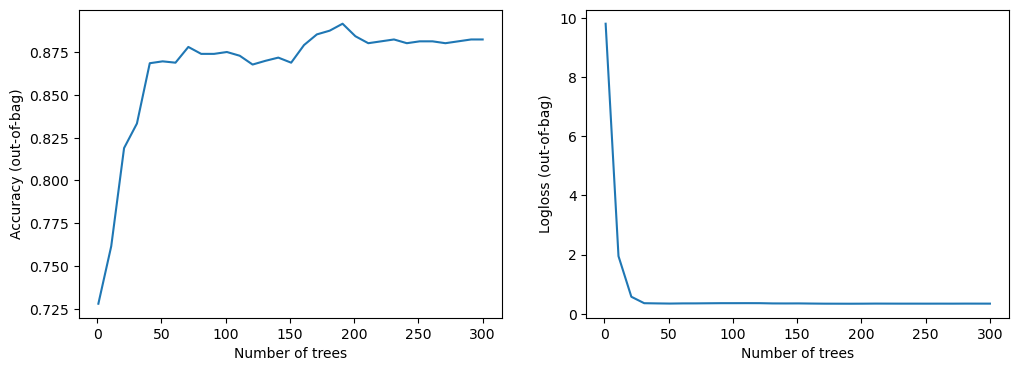


Train: 0.6168 Validation: 0.3305
##### Fold 5
Use /tmp/tmpzf2ylbfh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.558256. Found 555 examples.
Training model...
Model trained in 0:00:00.166777
Compiling model...


[INFO 23-07-21 14:45:28.1000 UTC kernel.cc:1242] Loading model from path /tmp/tmpzf2ylbfh/model/ with prefix a89dd98c4e3a447f
[INFO 23-07-21 14:45:28.1166 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10450 node(s), and 112 input feature(s).
[INFO 23-07-21 14:45:28.1167 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 14:45:28.1167 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 270ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.3279


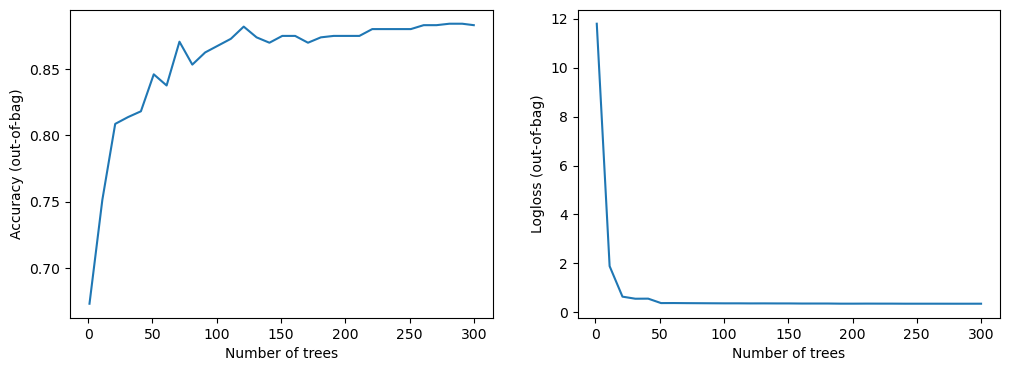


Train: 0.5066 Validation: 0.3279
##### Fold 6
Use /tmp/tmp4ab4o832 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.560049. Found 555 examples.
Training model...
Model trained in 0:00:00.147407
Compiling model...


[INFO 23-07-21 14:45:33.2609 UTC kernel.cc:1242] Loading model from path /tmp/tmp4ab4o832/model/ with prefix 2412abe82f7e4dca
[INFO 23-07-21 14:45:33.2774 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10332 node(s), and 112 input feature(s).
[INFO 23-07-21 14:45:33.2774 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 266ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3564


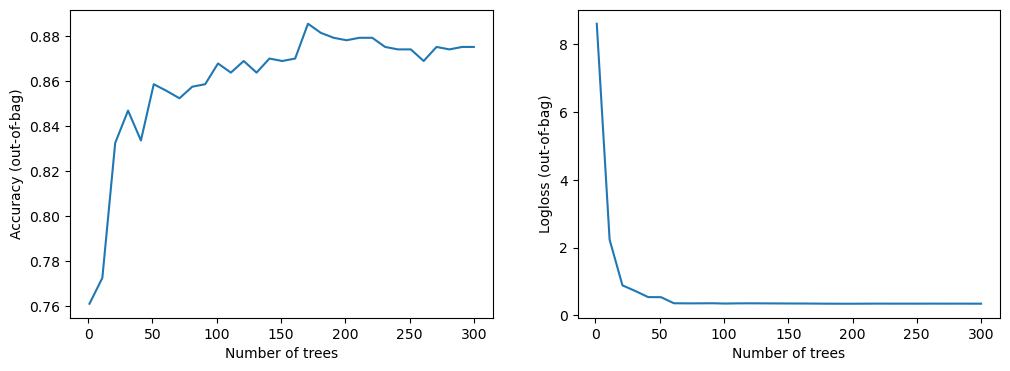


Train: 0.5020 Validation: 0.3564
##### Fold 7
Use /tmp/tmpbl7pgwka as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.676543. Found 555 examples.
Training model...
Model trained in 0:00:00.160751
Compiling model...


[INFO 23-07-21 14:45:38.5585 UTC kernel.cc:1242] Loading model from path /tmp/tmpbl7pgwka/model/ with prefix c1fa8678afb14fe0
[INFO 23-07-21 14:45:38.5760 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10312 node(s), and 112 input feature(s).
[INFO 23-07-21 14:45:38.5760 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 14:45:38.5761 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 263ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.4016


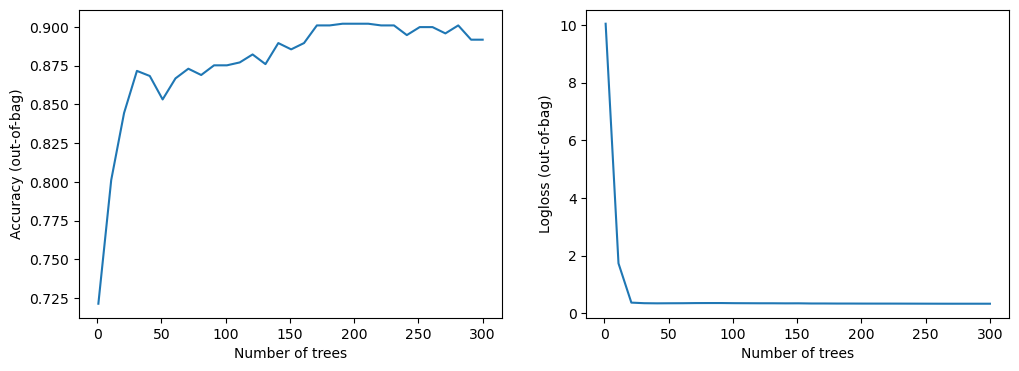


Train: 0.5269 Validation: 0.4016
##### Fold 8
Use /tmp/tmplerg0lwt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.568595. Found 556 examples.
Training model...
Model trained in 0:00:00.150187
Compiling model...


[INFO 23-07-21 14:45:43.8996 UTC kernel.cc:1242] Loading model from path /tmp/tmplerg0lwt/model/ with prefix 2e513ae99c084435
[INFO 23-07-21 14:45:43.9165 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10334 node(s), and 112 input feature(s).
[INFO 23-07-21 14:45:43.9165 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 274ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9344 - balanced_log_loss: 0.3344


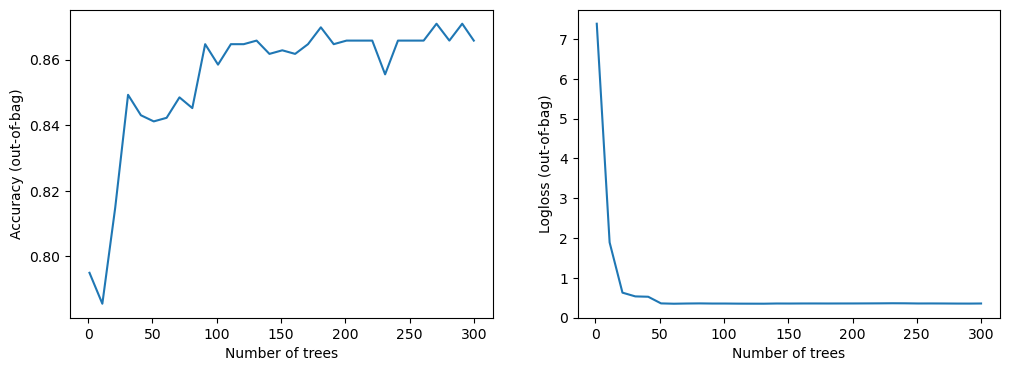


Train: 0.5754 Validation: 0.3344
##### Fold 9
Use /tmp/tmpzm7sr2q4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.523400. Found 556 examples.
Training model...
Model trained in 0:00:00.153742
Compiling model...


[INFO 23-07-21 14:45:48.8402 UTC kernel.cc:1242] Loading model from path /tmp/tmpzm7sr2q4/model/ with prefix 8a786ad150a241ed
[INFO 23-07-21 14:45:48.8583 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10174 node(s), and 112 input feature(s).
[INFO 23-07-21 14:45:48.8583 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 14:45:48.8583 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 284ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9344 - balanced_log_loss: 0.4160


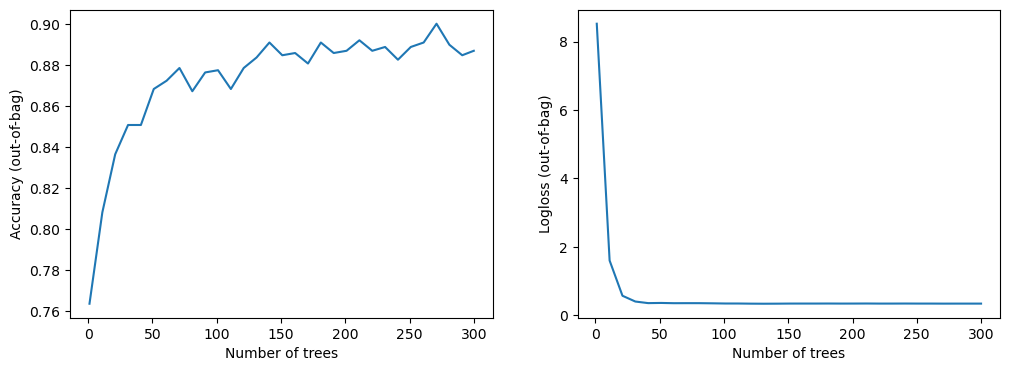


Train: 0.5072 Validation: 0.4160
##### Fold 10
Use /tmp/tmpjnadk6qp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.595548. Found 556 examples.
Training model...
Model trained in 0:00:00.156078
Compiling model...


[INFO 23-07-21 14:45:54.5845 UTC kernel.cc:1242] Loading model from path /tmp/tmpjnadk6qp/model/ with prefix a3083520e9af4084
[INFO 23-07-21 14:45:54.6018 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10428 node(s), and 112 input feature(s).
[INFO 23-07-21 14:45:54.6019 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 283ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.2804


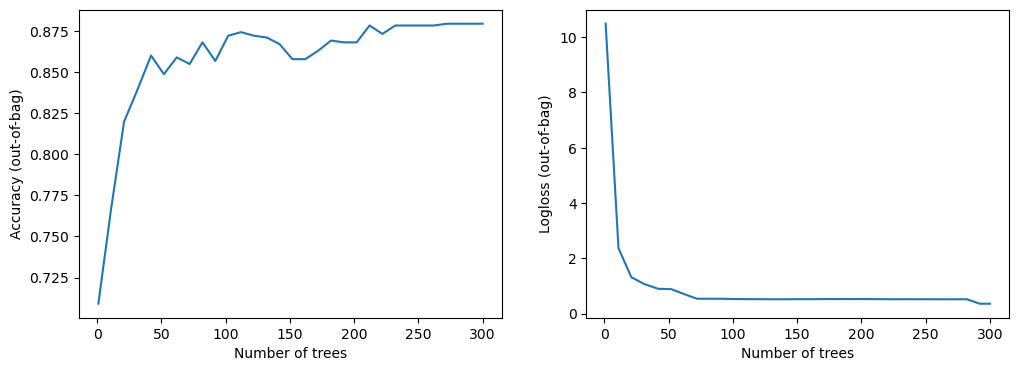


Train: 0.5957 Validation: 0.2804

Train mean: 0.4985 std: 0.1196

Validation mean: 0.3502 std: 0.0530


In [11]:
# RandomForestModel
if not SUBMITION:
    train_summary_rf_2, valid_summary_rf_2, test_summary_rf_2, model_rf_2,metrics_rf_2 = train_model(
        train=train_out,test=test_out, features=features,                                             
        n_splits=10,                    
        model_obj=tfdf.keras.RandomForestModel,           
        model_kwargs=dict(max_depth=6, num_trees=300),                                                  
        model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmp1gltf0wh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.976439. Found 555 examples.
Training model...
Model trained in 0:00:00.121520
Compiling model...


[INFO 23-07-21 14:45:59.1379 UTC kernel.cc:1242] Loading model from path /tmp/tmp1gltf0wh/model/ with prefix ff76091d23ca4301
[INFO 23-07-21 14:45:59.1559 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11186 node(s), and 58 input feature(s).
[INFO 23-07-21 14:45:59.1560 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 14:45:59.1560 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 210ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.2470


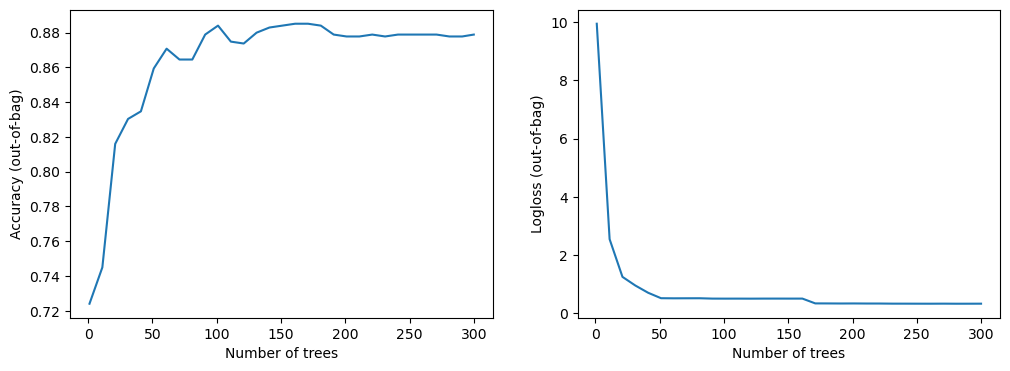


Train: 0.2012 Validation: 0.2470
##### Fold 2
Use /tmp/tmp1_fcovsk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.867893. Found 555 examples.
Training model...
Model trained in 0:00:00.122963
Compiling model...


[INFO 23-07-21 14:46:02.4492 UTC kernel.cc:1242] Loading model from path /tmp/tmp1_fcovsk/model/ with prefix d748fc39796545df
[INFO 23-07-21 14:46:02.4687 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11246 node(s), and 58 input feature(s).
[INFO 23-07-21 14:46:02.4688 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 212ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2757


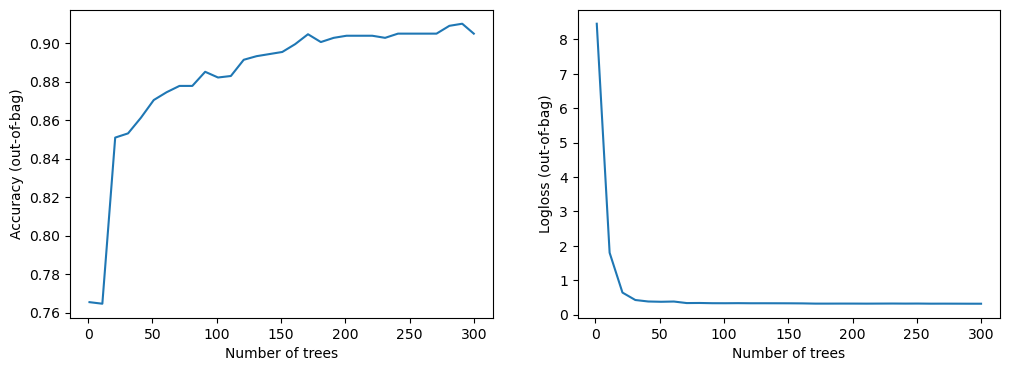


Train: 0.4433 Validation: 0.2757
##### Fold 3
Use /tmp/tmptz35vbt9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.904956. Found 555 examples.
Training model...
Model trained in 0:00:00.117653
Compiling model...


[INFO 23-07-21 14:46:05.8686 UTC kernel.cc:1242] Loading model from path /tmp/tmptz35vbt9/model/ with prefix e681dead85694fd2
[INFO 23-07-21 14:46:05.8861 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11012 node(s), and 58 input feature(s).
[INFO 23-07-21 14:46:05.8861 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 219ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3758


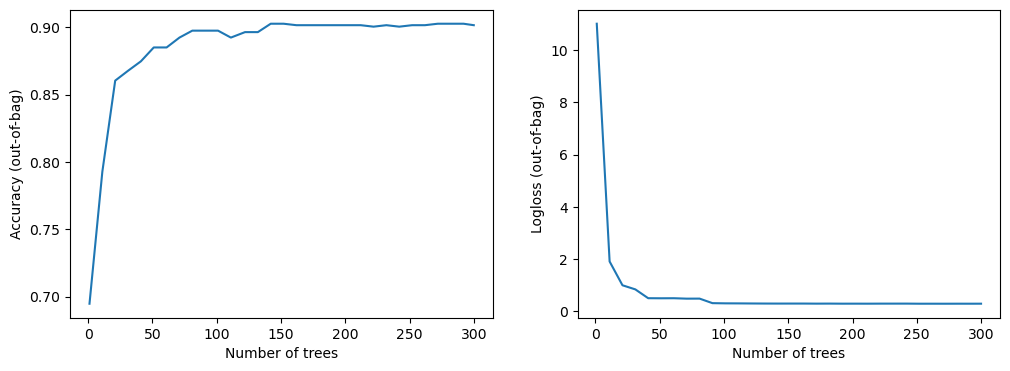


Train: 0.4615 Validation: 0.3758
##### Fold 4
Use /tmp/tmp66_7sgdj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.984158. Found 555 examples.
Training model...
Model trained in 0:00:00.125564
Compiling model...


[INFO 23-07-21 14:46:09.2801 UTC kernel.cc:1242] Loading model from path /tmp/tmp66_7sgdj/model/ with prefix 0c93c934c9504ccd
[INFO 23-07-21 14:46:09.2977 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11246 node(s), and 58 input feature(s).
[INFO 23-07-21 14:46:09.2977 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 14:46:09.2977 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 196ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.3001


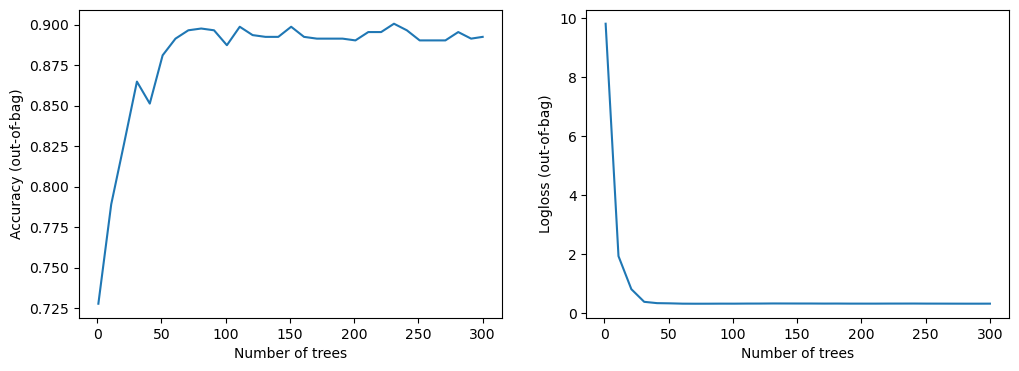


Train: 0.5660 Validation: 0.3001
##### Fold 5
Use /tmp/tmpo6gdqzmv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.954548. Found 555 examples.
Training model...
Model trained in 0:00:00.123366
Compiling model...


[INFO 23-07-21 14:46:12.6921 UTC kernel.cc:1242] Loading model from path /tmp/tmpo6gdqzmv/model/ with prefix 2d60de8a3a344406
[INFO 23-07-21 14:46:12.7099 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11294 node(s), and 58 input feature(s).
[INFO 23-07-21 14:46:12.7099 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 211ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2855


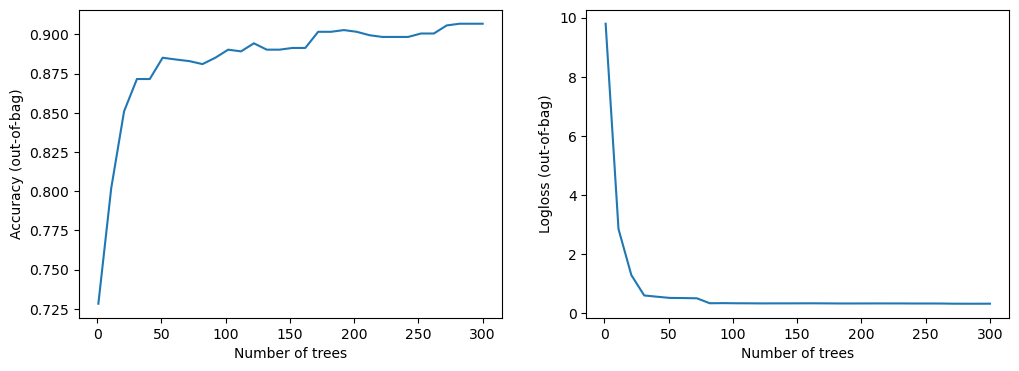


Train: 0.4859 Validation: 0.2855
##### Fold 6
Use /tmp/tmp8fbd0g8t as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.901470. Found 555 examples.
Training model...
Model trained in 0:00:00.119978
Compiling model...


[INFO 23-07-21 14:46:16.6953 UTC kernel.cc:1242] Loading model from path /tmp/tmp8fbd0g8t/model/ with prefix c36d45edb24445cc
[INFO 23-07-21 14:46:16.7135 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11238 node(s), and 58 input feature(s).
[INFO 23-07-21 14:46:16.7135 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 219ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3069


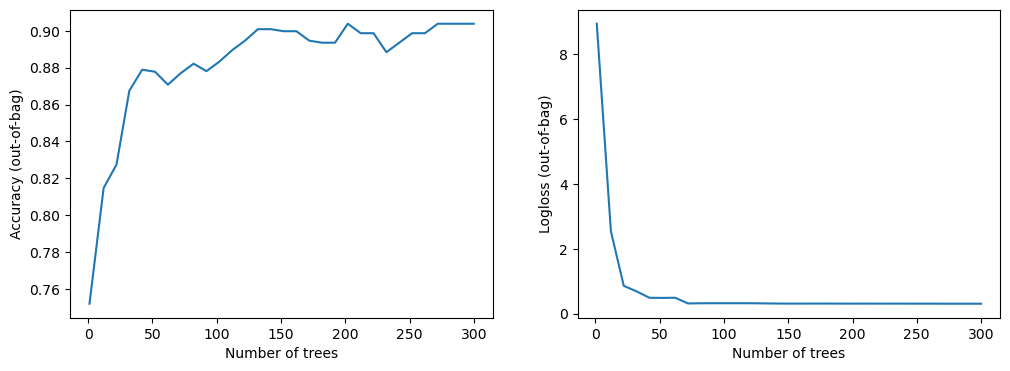


Train: 0.4704 Validation: 0.3069
##### Fold 7
Use /tmp/tmpdrgaoo82 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.981180. Found 555 examples.
Training model...
Model trained in 0:00:00.125519
Compiling model...


[INFO 23-07-21 14:46:20.1686 UTC kernel.cc:1242] Loading model from path /tmp/tmpdrgaoo82/model/ with prefix c14f00b6edbf418f
[INFO 23-07-21 14:46:20.1868 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11262 node(s), and 59 input feature(s).
[INFO 23-07-21 14:46:20.1868 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 14:46:20.1868 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 203ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3602


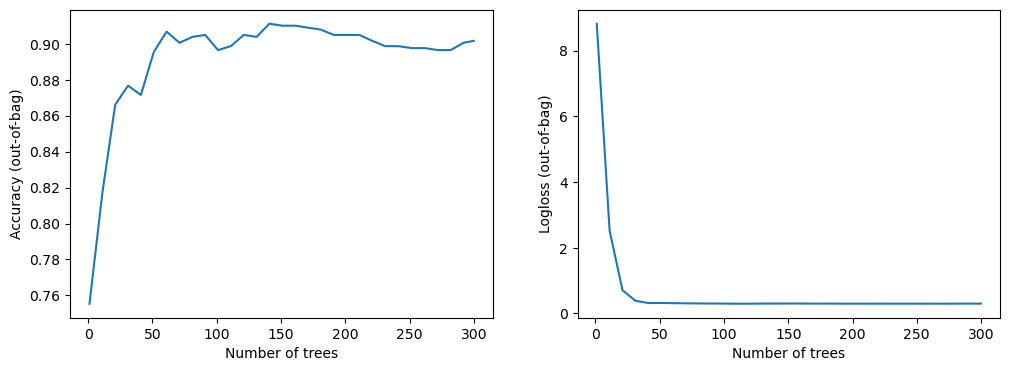


Train: 0.4883 Validation: 0.3602
##### Fold 8
Use /tmp/tmpdiomxw9n as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.746315. Found 556 examples.
Training model...
Model trained in 0:00:00.130314
Compiling model...


[INFO 23-07-21 14:46:24.4217 UTC kernel.cc:1242] Loading model from path /tmp/tmpdiomxw9n/model/ with prefix 4ba239d7626947e1
[INFO 23-07-21 14:46:24.4411 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11146 node(s), and 58 input feature(s).
[INFO 23-07-21 14:46:24.4412 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 210ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9508 - balanced_log_loss: 0.3318


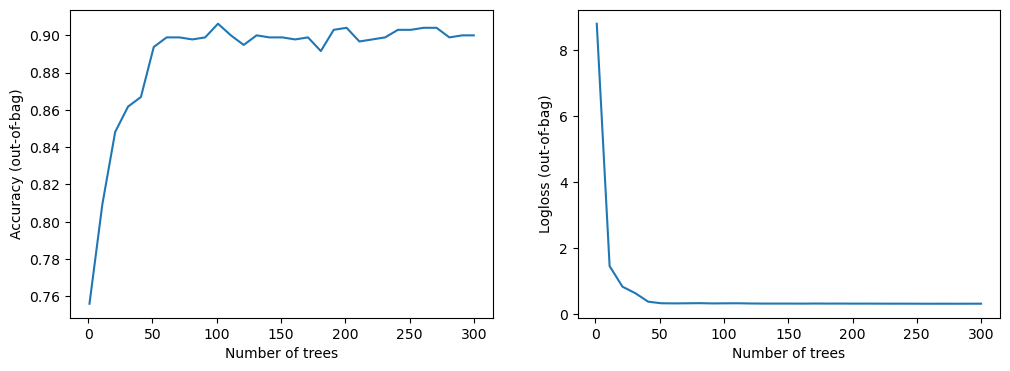


Train: 0.5488 Validation: 0.3318
##### Fold 9
Use /tmp/tmplouwqly8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.966674. Found 556 examples.
Training model...
Model trained in 0:00:00.147198
Compiling model...


[INFO 23-07-21 14:46:27.9909 UTC kernel.cc:1242] Loading model from path /tmp/tmplouwqly8/model/ with prefix 73a1a6f4ee554dc3
[INFO 23-07-21 14:46:28.0081 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11126 node(s), and 58 input feature(s).
[INFO 23-07-21 14:46:28.0083 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 211ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.3449


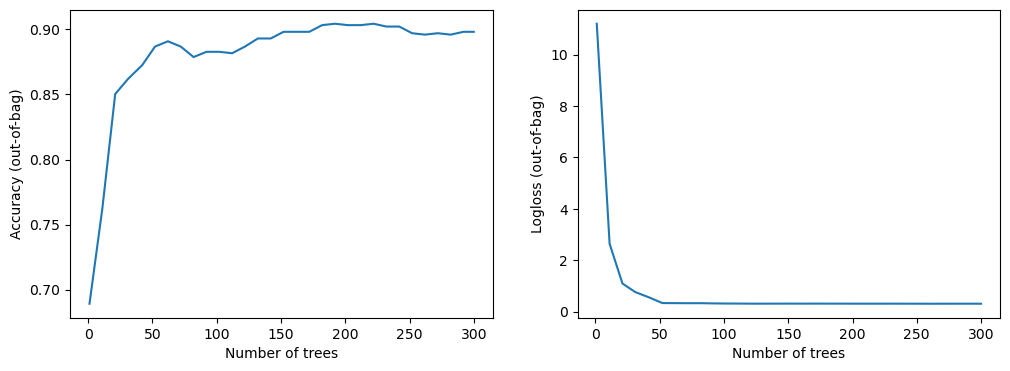


Train: 0.5168 Validation: 0.3449
##### Fold 10
Use /tmp/tmpleuwh0wv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.943823. Found 556 examples.
Training model...
Model trained in 0:00:00.128774
Compiling model...


[INFO 23-07-21 14:46:32.0344 UTC kernel.cc:1242] Loading model from path /tmp/tmpleuwh0wv/model/ with prefix 46fa99b7859f46cf
[INFO 23-07-21 14:46:32.0520 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11154 node(s), and 58 input feature(s).
[INFO 23-07-21 14:46:32.0520 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 14:46:32.0520 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 203ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9508 - balanced_log_loss: 0.2687


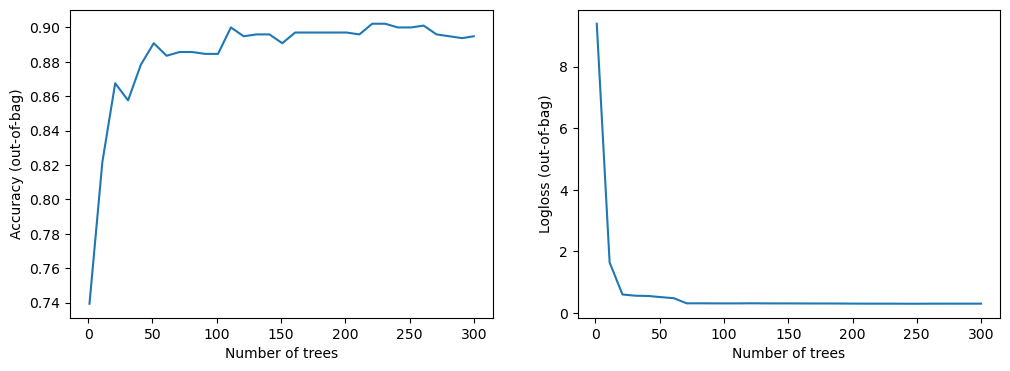


Train: 0.5330 Validation: 0.2687

Train mean: 0.4715 std: 0.1028

Validation mean: 0.3096 std: 0.0423


In [12]:
# RandomForestModel

features_slice = [i for i in features if len(i) > 2]

train_summary_rf_3, valid_summary_rf_3, test_summary_rf_3, model_rf_3,metrics_rf_3 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.RandomForestModel,           
    model_kwargs=dict(max_depth=6, num_trees=300),                                                  
    model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# GradientBoostedTreesModel

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpz1i9afjq as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:46:34.7275 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:46:34.7275 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:46:34.7275 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.957619. Found 555 examples.
Training model...
Model trained in 0:00:02.545122
Compiling model...


[INFO 23-07-21 14:46:38.2306 UTC kernel.cc:1242] Loading model from path /tmp/tmpz1i9afjq/model/ with prefix d285c727f2fe4e2b
[INFO 23-07-21 14:46:38.2388 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 203ms/step - loss: 0.0000e+00 - binary_accuracy: 1.0000 - balanced_log_loss: 0.0299


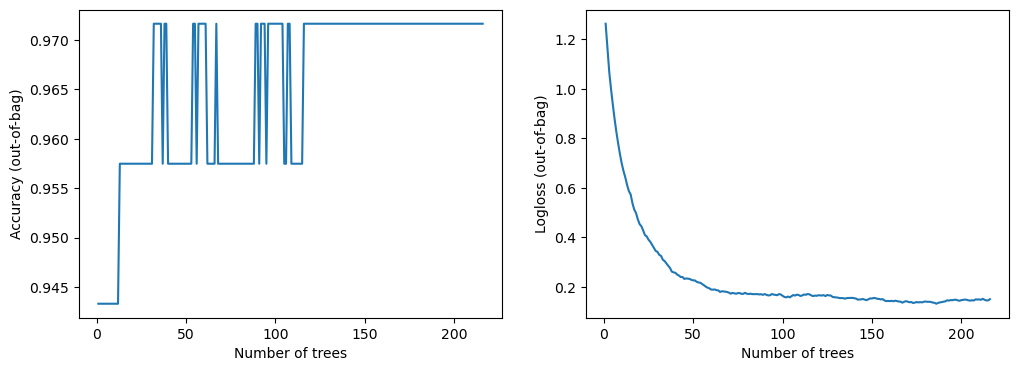


Train: 0.0060 Validation: 0.0299
##### Fold 2
Use /tmp/tmpf0bf3imm as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:46:40.5997 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:46:40.5997 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:46:40.5997 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.915570. Found 555 examples.
Training model...
Model trained in 0:00:02.240076
Compiling model...


[INFO 23-07-21 14:46:43.7589 UTC kernel.cc:1242] Loading model from path /tmp/tmpf0bf3imm/model/ with prefix 76b47c0cca3846c9
[INFO 23-07-21 14:46:43.7669 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 14:46:43.7669 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 205ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9516 - balanced_log_loss: 0.1438


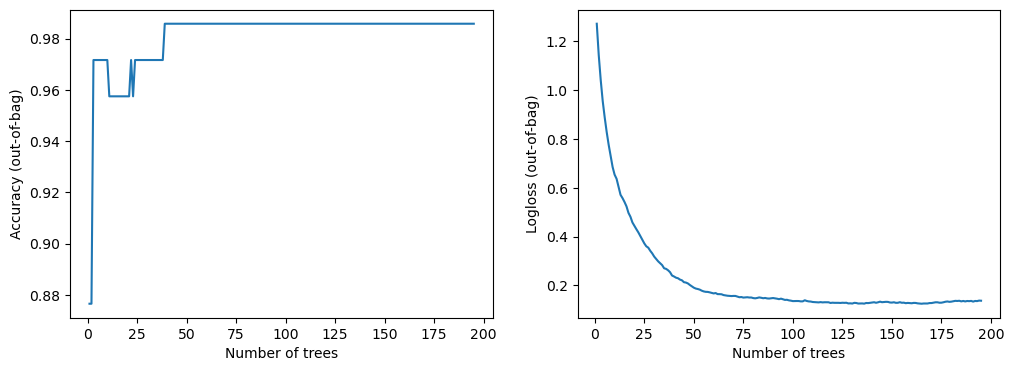


Train: 0.0360 Validation: 0.1438
##### Fold 3
Use /tmp/tmp19gmh0t4 as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:46:46.0143 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:46:46.0143 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:46:46.0144 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.954617. Found 555 examples.
Training model...
Model trained in 0:00:02.906081
Compiling model...


[INFO 23-07-21 14:46:49.8741 UTC kernel.cc:1242] Loading model from path /tmp/tmp19gmh0t4/model/ with prefix 8b72cbba19714b1e
[INFO 23-07-21 14:46:49.8845 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 202ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.8838


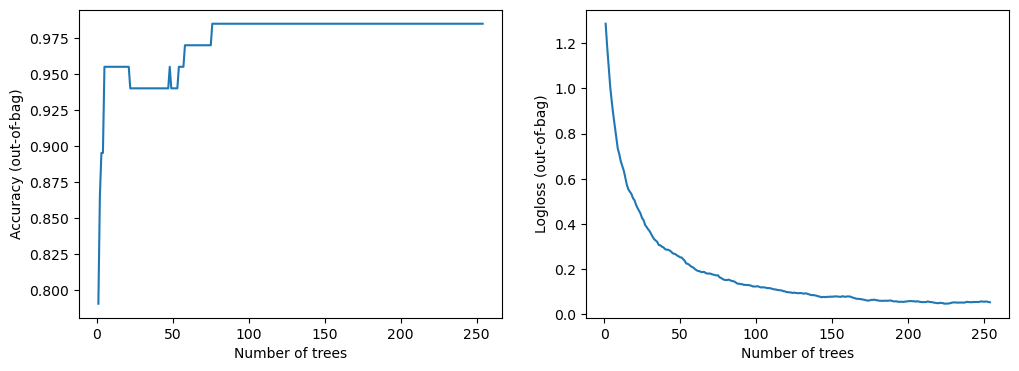


Train: 0.1457 Validation: 0.8838
##### Fold 4
Use /tmp/tmp8euo7i9y as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:46:53.8437 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:46:53.8438 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:46:53.8438 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.914822. Found 555 examples.
Training model...
Model trained in 0:00:02.928855
Compiling model...


[INFO 23-07-21 14:46:57.6857 UTC kernel.cc:1242] Loading model from path /tmp/tmp8euo7i9y/model/ with prefix 1d1ea2c5b7c44c02
[INFO 23-07-21 14:46:57.6960 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 14:46:57.6960 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 213ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.3553


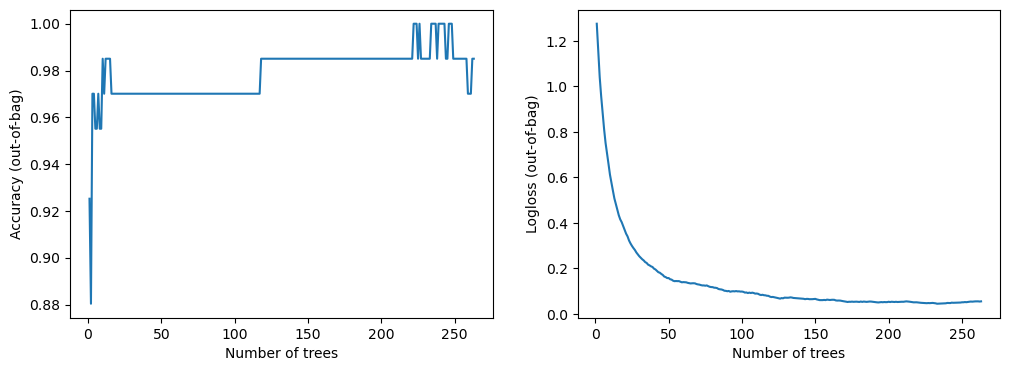


Train: 0.8856 Validation: 0.3553
##### Fold 5
Use /tmp/tmpzr9i8qtp as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:47:00.0296 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:00.0297 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:00.0297 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.889299. Found 555 examples.
Training model...
Model trained in 0:00:03.133353
Compiling model...


[INFO 23-07-21 14:47:04.0497 UTC kernel.cc:1242] Loading model from path /tmp/tmpzr9i8qtp/model/ with prefix 50acc266ab474ea0
[INFO 23-07-21 14:47:04.0616 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 212ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.5371


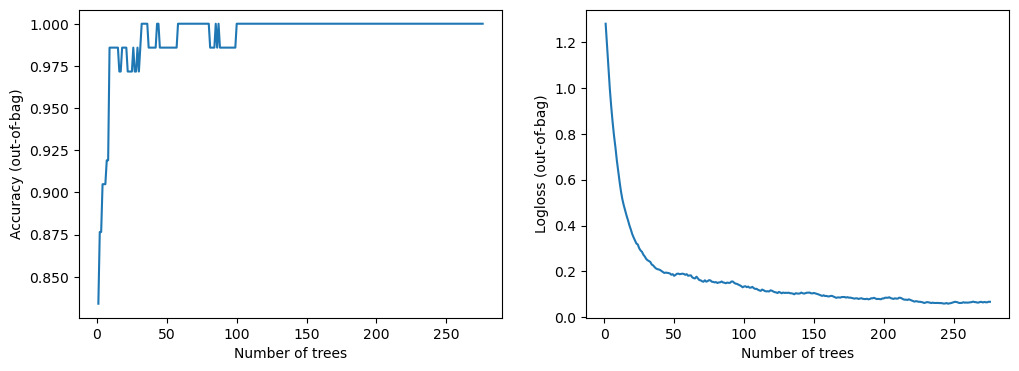


Train: 0.3576 Validation: 0.5371
##### Fold 6
Use /tmp/tmp_29_f3nz as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:47:07.8941 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:07.8942 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:07.8942 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.902229. Found 555 examples.
Training model...
Model trained in 0:00:01.743175
Compiling model...


[INFO 23-07-21 14:47:10.5421 UTC kernel.cc:1242] Loading model from path /tmp/tmp_29_f3nz/model/ with prefix 5161d4e93fe34de2
[INFO 23-07-21 14:47:10.5476 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 14:47:10.5476 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 216ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.2998


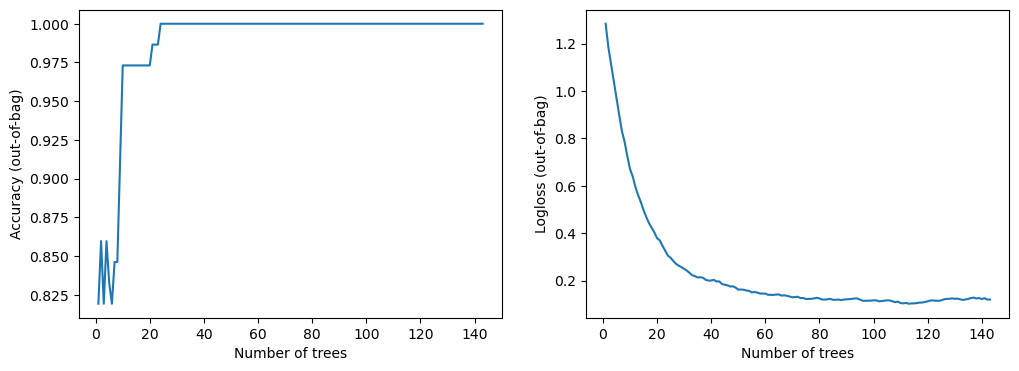


Train: 0.5467 Validation: 0.2998
##### Fold 7
Use /tmp/tmpu3cs6t8v as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:47:12.9386 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:12.9387 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:12.9387 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.972191. Found 555 examples.
Training model...
Model trained in 0:00:00.746904
Compiling model...


[INFO 23-07-21 14:47:14.6656 UTC kernel.cc:1242] Loading model from path /tmp/tmpu3cs6t8v/model/ with prefix 5c73d6d76b0641fb
[INFO 23-07-21 14:47:14.6677 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 259ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3052


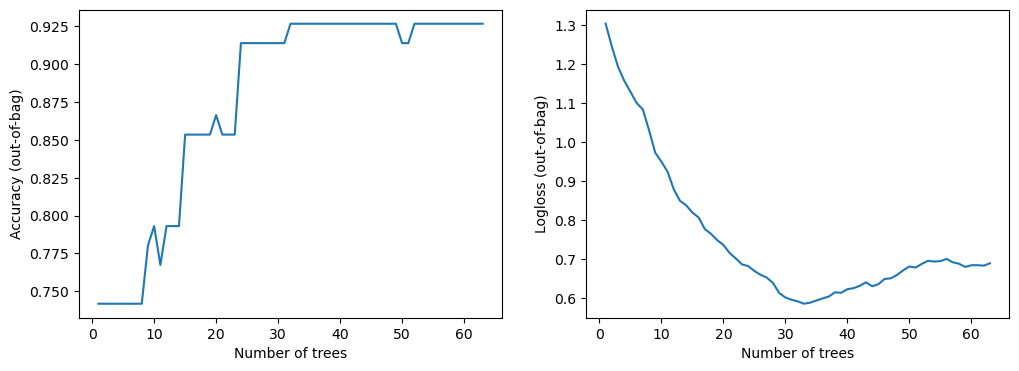


Train: 0.4053 Validation: 0.3052
##### Fold 8
Use /tmp/tmpu98j3nw5 as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:47:18.4359 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:18.4361 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:18.4362 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.951014. Found 556 examples.
Training model...
Model trained in 0:00:00.800588
Compiling model...


[INFO 23-07-21 14:47:20.1951 UTC kernel.cc:1242] Loading model from path /tmp/tmpu98j3nw5/model/ with prefix 8f99cb474cb24da9
[INFO 23-07-21 14:47:20.1975 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 200ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.3190


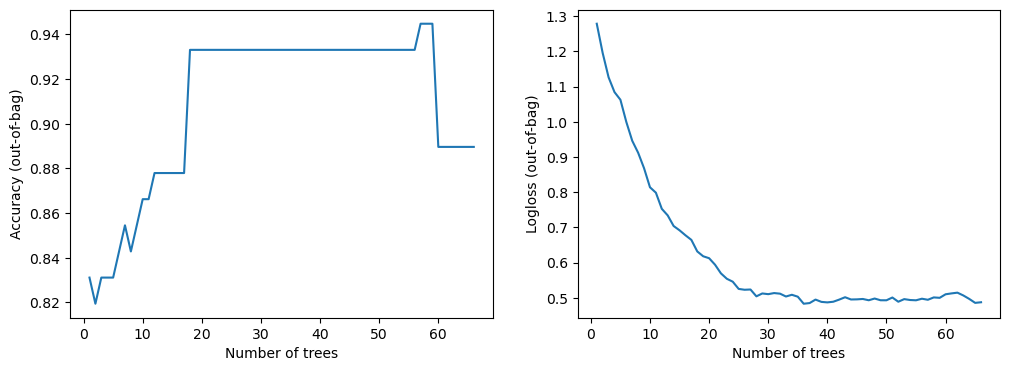


Train: 0.4007 Validation: 0.3190
##### Fold 9
Use /tmp/tmpzkh7iroh as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:47:23.7722 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:23.7722 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:23.7722 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.905485. Found 556 examples.
Training model...
Model trained in 0:00:01.192166
Compiling model...


[INFO 23-07-21 14:47:25.8723 UTC kernel.cc:1242] Loading model from path /tmp/tmpzkh7iroh/model/ with prefix 2292295ef5a84c60
[INFO 23-07-21 14:47:25.8761 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 14:47:25.8761 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 201ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9016 - balanced_log_loss: 0.4456


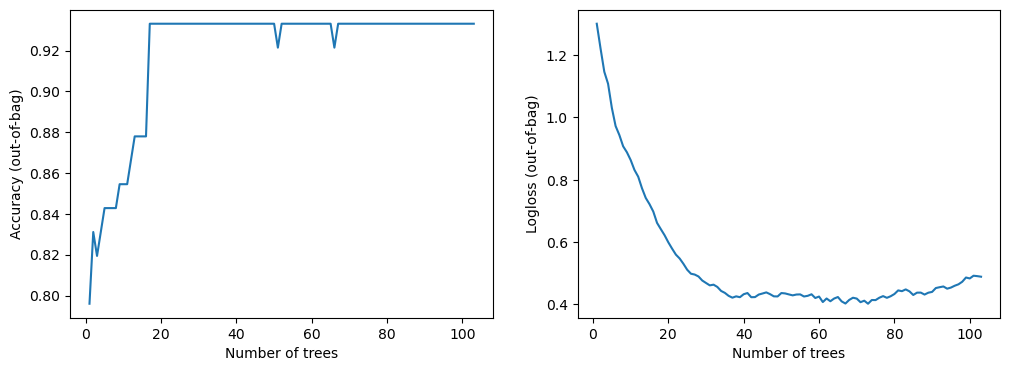


Train: 0.3539 Validation: 0.4456
##### Fold 10
Use /tmp/tmphckw47z8 as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:47:28.1886 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:28.1886 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:28.1886 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.937030. Found 556 examples.
Training model...
Model trained in 0:00:00.736067
Compiling model...


[INFO 23-07-21 14:47:29.8672 UTC kernel.cc:1242] Loading model from path /tmp/tmphckw47z8/model/ with prefix 8eca0645eecb463e
[INFO 23-07-21 14:47:29.8694 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 210ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9344 - balanced_log_loss: 0.2912


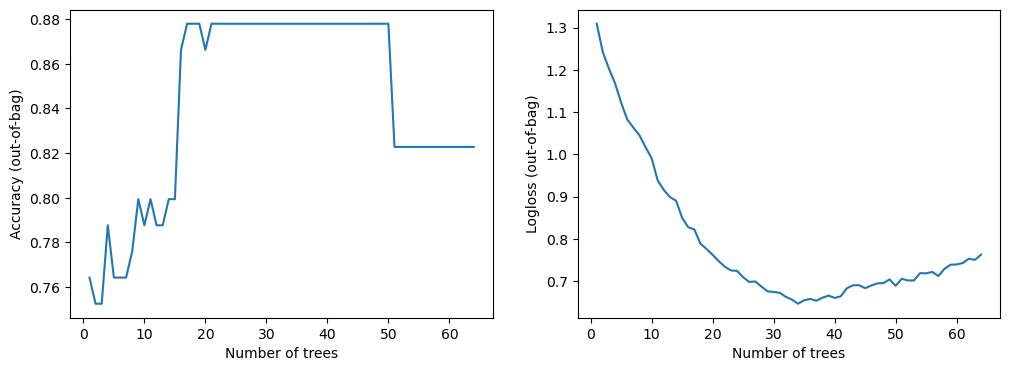


Train: 0.5554 Validation: 0.2912

Train mean: 0.3693 std: 0.2642

Validation mean: 0.3611 std: 0.2314


In [13]:
# GradientBoostedTreesModel

if not SUBMITION:

    features_slice = [i for i in features if len(i) > 2]

    train_summary_gbt_1, valid_summary_gbt_1, test_summary_gbt_1, model_gbt_1,metrics_gbt_1 = train_model(
        train=train_out,test=test_out, features=features_slice,                                             
        n_splits=10,                    
        model_obj=tfdf.keras.GradientBoostedTreesModel,            
        model_kwargs=dict(max_depth=5, num_trees=1000),                                                  
        model_compile_kwargs=dict(metrics=[metrics.binary_accuracy, BalancedLogLoss()]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpvr3eeyd0 as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:47:32.3549 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:32.3549 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:32.3549 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.974881. Found 555 examples.
Training model...
Model trained in 0:00:01.226385
Compiling model...


[INFO 23-07-21 14:47:34.5597 UTC kernel.cc:1242] Loading model from path /tmp/tmpvr3eeyd0/model/ with prefix cf25d5fcb1f64bba
[INFO 23-07-21 14:47:34.5653 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 215ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.1640


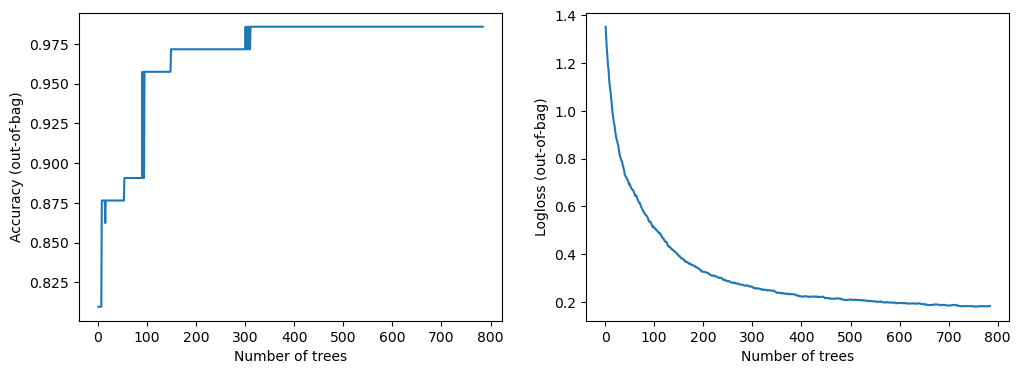


Train: 0.1127 Validation: 0.1640
##### Fold 2
Use /tmp/tmpw517rnel as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:47:37.8159 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:37.8160 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:37.8160 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.966247. Found 555 examples.
Training model...
Model trained in 0:00:00.734786
Compiling model...


[INFO 23-07-21 14:47:39.5225 UTC kernel.cc:1242] Loading model from path /tmp/tmpw517rnel/model/ with prefix 4a334f90b9eb4cde
[INFO 23-07-21 14:47:39.5263 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 14:47:39.5263 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 199ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.1576


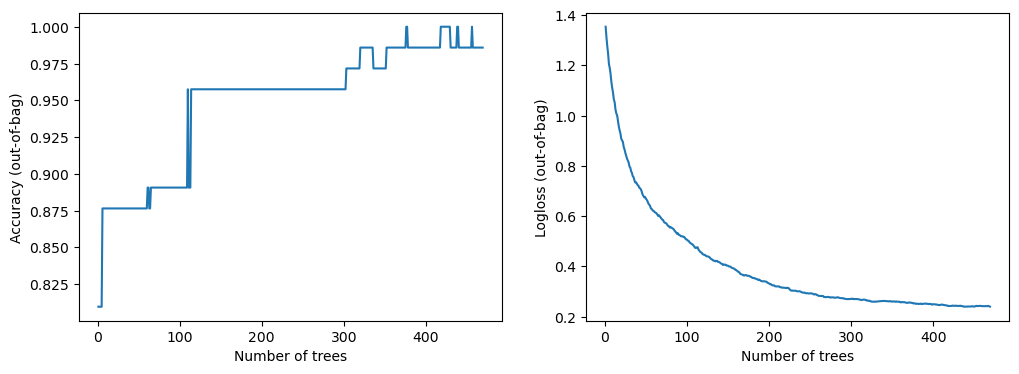


Train: 0.3058 Validation: 0.1576
##### Fold 3
Use /tmp/tmp82j9jgva as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:47:41.8305 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:41.8305 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:41.8305 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.922692. Found 555 examples.
Training model...
Model trained in 0:00:00.876278
Compiling model...


[INFO 23-07-21 14:47:43.6332 UTC kernel.cc:1242] Loading model from path /tmp/tmp82j9jgva/model/ with prefix d383995af6b64c19
[INFO 23-07-21 14:47:43.6368 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 208ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9032 - balanced_log_loss: 0.3384


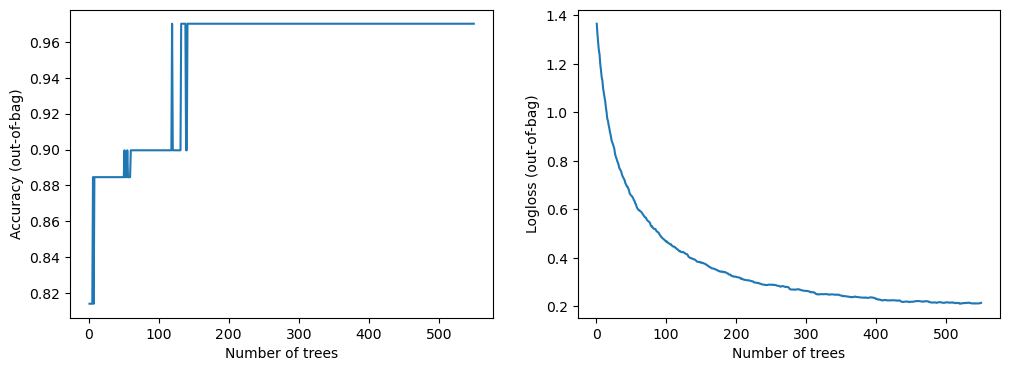


Train: 0.2765 Validation: 0.3384
##### Fold 4
Use /tmp/tmpwjd_8gmc as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:47:47.1066 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:47.1066 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:47.1066 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.015232. Found 555 examples.
Training model...
Model trained in 0:00:00.726525
Compiling model...


[INFO 23-07-21 14:47:48.8515 UTC kernel.cc:1242] Loading model from path /tmp/tmpwjd_8gmc/model/ with prefix c5de66c77eda4d75
[INFO 23-07-21 14:47:48.8559 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 226ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.2671


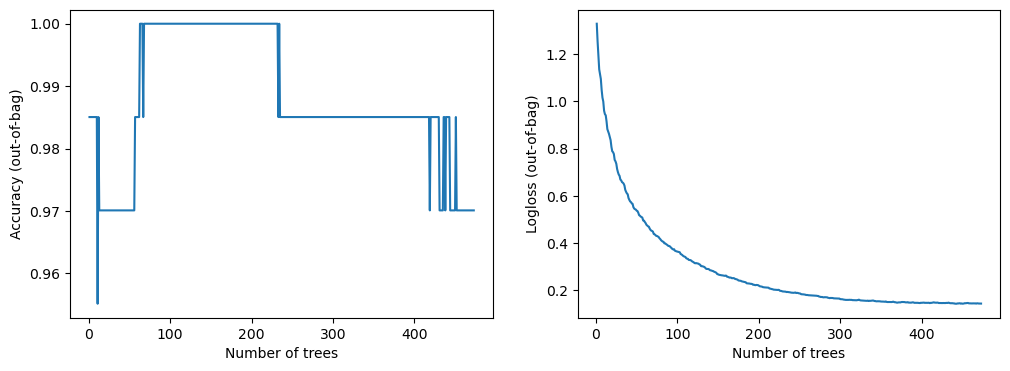


Train: 0.4713 Validation: 0.2671
##### Fold 5
Use /tmp/tmppjn1rkpj as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:47:51.1817 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:51.1819 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:51.1819 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.908356. Found 555 examples.
Training model...
Model trained in 0:00:01.104968
Compiling model...


[INFO 23-07-21 14:47:53.1994 UTC kernel.cc:1242] Loading model from path /tmp/tmppjn1rkpj/model/ with prefix a4c9b1350a304941
[INFO 23-07-21 14:47:53.2039 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 14:47:53.2039 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 221ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.2613


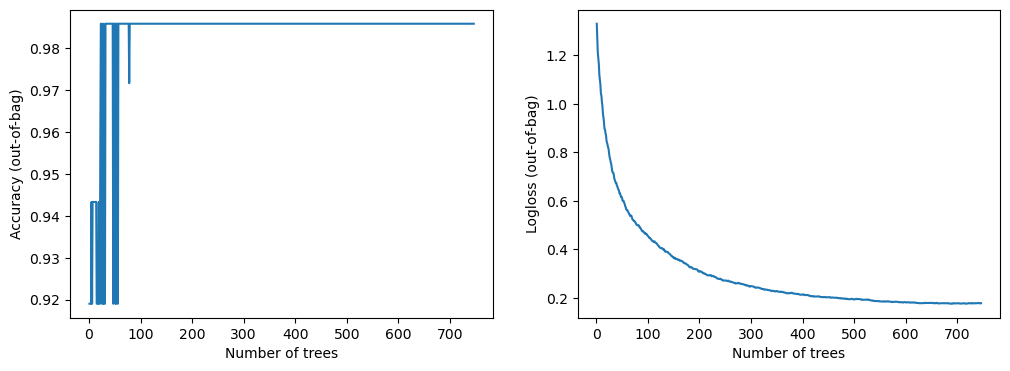


Train: 0.3730 Validation: 0.2613
##### Fold 6
Use /tmp/tmpkkrauzwt as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:47:55.5466 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:55.5466 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:47:55.5466 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.945408. Found 555 examples.
Training model...
Model trained in 0:00:01.306381
Compiling model...


[INFO 23-07-21 14:47:57.8055 UTC kernel.cc:1242] Loading model from path /tmp/tmpkkrauzwt/model/ with prefix 483bdc89f9ce4e76
[INFO 23-07-21 14:47:57.8105 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 205ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2744


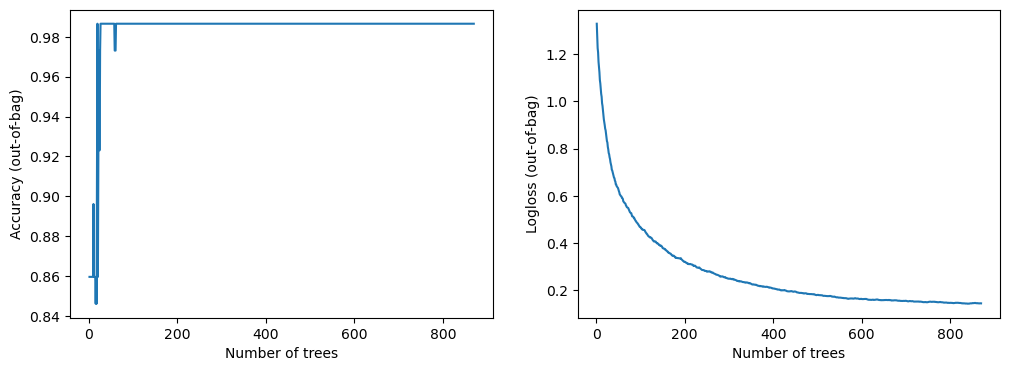


Train: 0.3571 Validation: 0.2744
##### Fold 7
Use /tmp/tmpcv9z0uj9 as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:48:00.8376 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:48:00.8377 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:48:00.8377 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.880510. Found 555 examples.
Training model...
Model trained in 0:00:00.578233
Compiling model...


[INFO 23-07-21 14:48:02.3019 UTC kernel.cc:1242] Loading model from path /tmp/tmpcv9z0uj9/model/ with prefix 634e0ad55e4a44ae
[INFO 23-07-21 14:48:02.3045 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 199ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9032 - balanced_log_loss: 0.2420


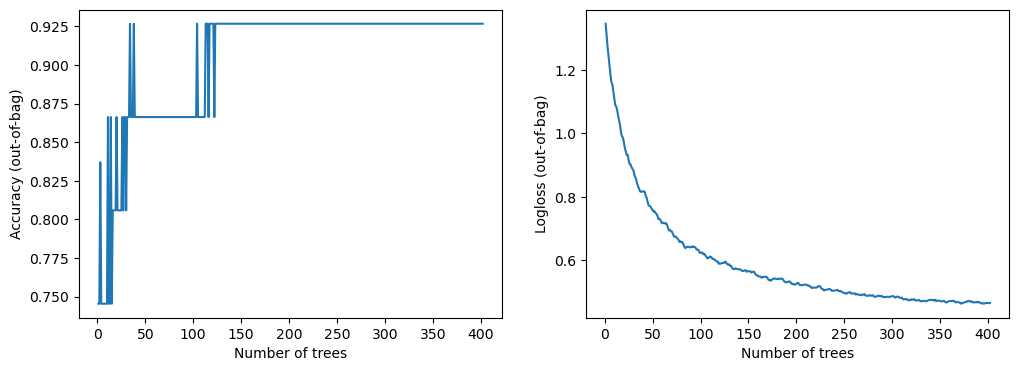


Train: 0.4262 Validation: 0.2420
##### Fold 8
Use /tmp/tmpspcs6pjq as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:48:05.5724 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:48:05.5724 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:48:05.5724 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.007497. Found 556 examples.
Training model...
Model trained in 0:00:00.625621
Compiling model...


[INFO 23-07-21 14:48:07.2132 UTC kernel.cc:1242] Loading model from path /tmp/tmpspcs6pjq/model/ with prefix 290b687228644885
[INFO 23-07-21 14:48:07.2157 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 14:48:07.2158 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 234ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.2632


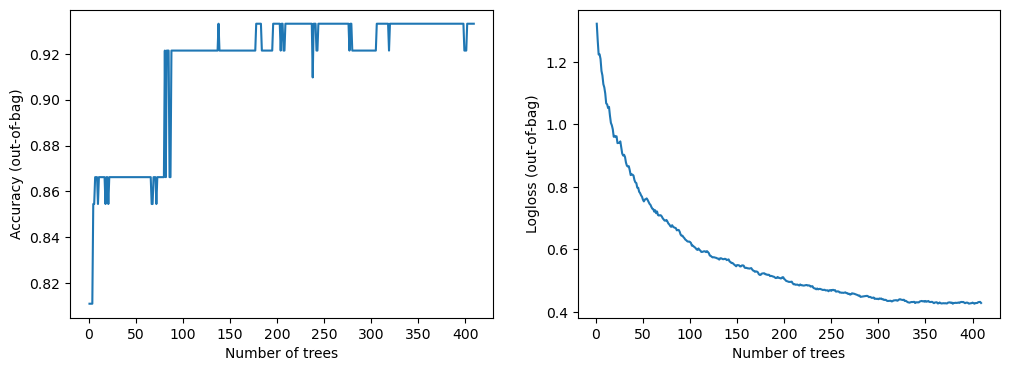


Train: 0.3848 Validation: 0.2632
##### Fold 9
Use /tmp/tmp0zl9e7cx as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:48:09.6511 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:48:09.6512 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:48:09.6512 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.017274. Found 556 examples.
Training model...
Model trained in 0:00:00.808350
Compiling model...


[INFO 23-07-21 14:48:11.4816 UTC kernel.cc:1242] Loading model from path /tmp/tmp0zl9e7cx/model/ with prefix 80de04a965964190
[INFO 23-07-21 14:48:11.4849 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 223ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8852 - balanced_log_loss: 0.3122


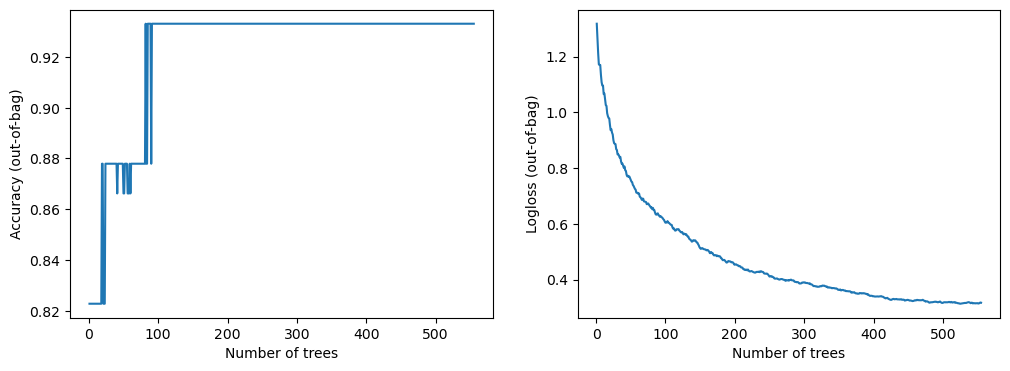


Train: 0.3803 Validation: 0.3122
##### Fold 10
Use /tmp/tmps8tr_wg0 as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:48:13.9125 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:48:13.9125 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:48:13.9125 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.941066. Found 556 examples.
Training model...
Model trained in 0:00:00.637977
Compiling model...


[INFO 23-07-21 14:48:15.4962 UTC kernel.cc:1242] Loading model from path /tmp/tmps8tr_wg0/model/ with prefix f6f9ea03f1fa4f51
[INFO 23-07-21 14:48:15.4991 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 197ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.1399


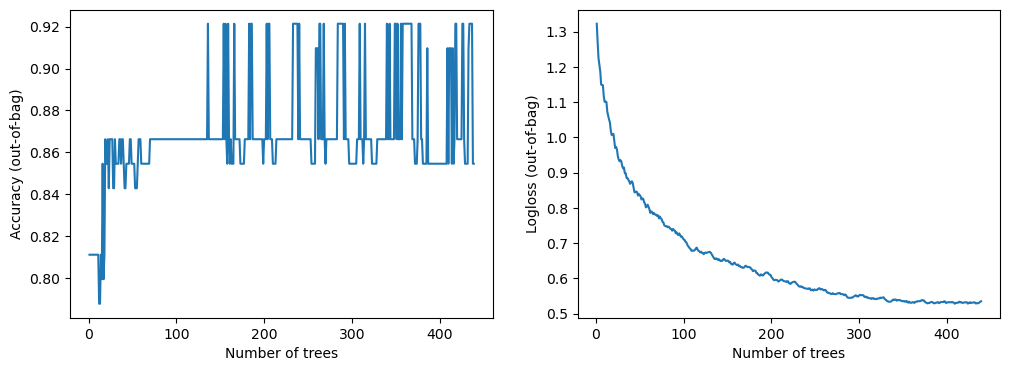


Train: 0.4631 Validation: 0.1399

Train mean: 0.3551 std: 0.1051

Validation mean: 0.2420 std: 0.0670


In [14]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

train_summary_gbt_2, valid_summary_gbt_2, test_summary_gbt_2, model_gbt_2,metrics_gbt_2 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.GradientBoostedTreesModel,            
    model_kwargs=dict(max_depth=2, num_trees=1000),                                                  
    model_compile_kwargs=dict(metrics=[metrics.binary_accuracy, BalancedLogLoss()]))

# TabPFN

In [15]:
def balanced_logloss_np(y_true: np.array, y_pred: np.array) -> float:
    
    # Correct Values
    min_val = 1e-15
    max_val = 0.999999999999999

    y_pred = np.minimum(y_pred, [max_val])
    y_pred = np.maximum(y_pred, [min_val])
    
    y_pred_1 = y_pred
    y_pred_0 = 1-y_pred

    log_y_pred_1 = np.reshape(np.log(y_pred_1),[-1,1])
    log_y_pred_0 = np.reshape(np.log(y_pred_0),[-1,1])

    y_1 = np.reshape(y_true,[1,-1])
    y_0 = (y_1-1)*(-1)

    logloss_1 = -np.dot(y_1,log_y_pred_1)[0][0]/np.sum(y_1)
    logloss_0 = -np.dot(y_0,log_y_pred_0)[0][0]/np.sum(y_0)

    av_logloss = (logloss_1+logloss_0)/2
    
    return av_logloss

def train_model_tabpfn_one(train: pd.DataFrame, test: pd.DataFrame, features: list, label = "Class") -> (pd.DataFrame, dict, dict):

    # Create a dataframe of required size with zero values.
    test_summary = pd.DataFrame(data=np.full((len(test.index),1), np.nan),index=test.index)
    train_summary = pd.DataFrame(data=np.full((len(train.index),1), np.nan),index=train.index)
    # Create an empty dictionary to store the models trained for each fold.
    metrics = {}

    # Select only feature columns for training.
    train_df = train[features+[label]]

    # Define & Train the model and metrics
    model = TabPFNClassifier(N_ensemble_configurations=64)
    model.fit(train_df[features],train_df[label])

    # Make predictions
    p_train = model.predict_proba(train_df[features])[:,1]
    p_test = model.predict_proba(test[features])[:,1]

    # Predict value for validation/Submition data
    test_summary[0] = p_test.flatten() 
    train_summary[0] = p_train.flatten() 
    
    # Evaluate and store the metrics in respective dicts
    metrics['balanced_logloss'] = balanced_logloss_np(y_true=train_df[label].values,y_pred=p_train)
    print(f"\nTrain: {metrics['balanced_logloss']:.4f}")
    
            
    return train_summary, test_summary, model, metrics


def train_model_tabpfn_cv(train: pd.DataFrame, test: pd.DataFrame, features: list, label = "Class",
                n_splits: int = 6) -> (pd.DataFrame, dict,  dict):

    # Create a various frames
    train_summary = pd.DataFrame(data=np.full((len(train.index),n_splits), np.nan), index=train.index) # For In-Sample Predictions of each Fold
    
    valid_summary = pd.DataFrame(data=np.full((len(train.index),1), np.nan), index=train.index) # For Out-of-Sample Prediction of each Fold
    
    test_summary = pd.DataFrame(data=np.full((len(test.index),n_splits), np.nan),index=test.index) # For Test (Sumbition) Predictions of each Fold's Model
    

    # Create an empty dictionary to store the models trained for each fold.
    models = {}
    metrics = {}
    balanced_logloss_train = {}
    balanced_logloss_val = {}
    
    # Loop through each fold
    skf = StratifiedKFold(n_splits=n_splits)
    
    for i, (train_index, valid_index) in enumerate(skf.split(X=train,y=train['Class'])):
            print('##### Fold',i+1)

            # Fetch values corresponding to the index 
            train_df = train.iloc[train_index]
            valid_df = train.iloc[valid_index]
            train_ids = train_df.index.values
            valid_ids = valid_df.index.values

            # Select only feature columns for training.
            train_df = train_df[features+[label]]
            valid_df = valid_df[features+[label]]

            # Define & Train the model
            model = TabPFNClassifier(N_ensemble_configurations=64)
            model.fit(train_df[features],train_df[label])

            # Store the model
            models[f"fold_{i+1}"] = model

            # Predict value for validation/Submition data
            p_train = model.predict_proba(train_df[features])[:,1]
            p_val = model.predict_proba(valid_df[features])[:,1]
            p_sub = model.predict_proba(test[features])[:,1]
            
            # Predict Values
            train_summary.loc[train_ids, i] = p_train
            valid_summary.loc[valid_ids, 0] = p_val
            test_summary[i] = p_sub

            # Evaluate and store the metrics in respective dicts
            train_metric = balanced_logloss_np(y_true=train_df[label].values,y_pred=p_train)
            val_metric = balanced_logloss_np(y_true=valid_df[label].values,y_pred=p_val)
            
            balanced_logloss_train[f"fold_{i+1}"] = train_metric
            balanced_logloss_val[f"fold_{i+1}"] = val_metric
            
            print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")
    
    metrics['train'] = balanced_logloss_train
    metrics['val'] = balanced_logloss_val

    print(f"\nTrain mean: {pd.Series(balanced_logloss_train).mean():.4f} std: {pd.Series(balanced_logloss_train).std():.4f}")
    print(f"\nValidation mean: {pd.Series(balanced_logloss_val).mean():.4f} std: {pd.Series(balanced_logloss_val).std():.4f}")
            
    return train_summary, valid_summary, test_summary, models,metrics

In [16]:
# TabPFN tabpfn_
if not SUBMITION:
    features_slice = [i for i in features if len(i) > 2]
    train_summary_tabpfn_2, test_summary_tabpfn_2, model_tabpfn_1, metrics_tabpfn_1 = train_model_tabpfn_one(
        train=train_out,test=test_out, features=features_slice)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0515


In [17]:
# TabPFN tabpfn_
features_slice = [i for i in features if len(i) > 2]
train_summary_tabpfn_2, valid_summary_tabpfn_2, test_summary_tabpfn_2, model_tabpfn_2, metrics_tabpfn_2 = train_model_tabpfn_cv(
    train=train_out,test=test_out, features=features_slice, n_splits=6)

##### Fold 1
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0559 Validation: 0.1706
##### Fold 2
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0553 Validation: 0.2929
##### Fold 3
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0538 Validation: 0.2968
##### Fold 4
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0448 Validation: 0.1985
##### Fold 5
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0518 Validation: 0.4682
##### Fold 6
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0511 Validation: 0.1178

Train mean: 0.0521 std: 0.0040

Validation mean: 0.2575 std: 0.1247


# Ensemble CV

In [18]:
class EnsembleCV(object):
    def __init__(self):
        self.is_fitted = False
        self.weights = None
        return
    
    def fit(self, X: pd.DataFrame) -> None:
        self.weights = None
        return
    
    @staticmethod
    def predict(X: pd.DataFrame) -> pd.Series:
        # Take conservative estimate
        X_ = X.max(axis=1) #.to_frame()
        # Fillna by 1
        X_ = X_.fillna(1)
        return X_

In [19]:
rf_ensemble = EnsembleCV()
gbt_ensemble = EnsembleCV()
tabpfn_ensemble = EnsembleCV()

test_rf_ensemble = rf_ensemble.predict(X=test_summary_rf_3)
test_gbt_ensemble = gbt_ensemble.predict(X=test_summary_gbt_2)
test_tabpfn_ensemble = tabpfn_ensemble.predict(X=test_summary_tabpfn_2)

In [20]:
train_out['Class_RF'] = rf_ensemble.predict(X=train_summary_rf_3)
test_out['Class_RF'] = rf_ensemble.predict(X=test_summary_rf_3)

print(pd.Series(metrics_rf_3['train']).mean())
print(pd.Series(metrics_rf_3['val']).mean())
print(balanced_logloss_np(y_true=train_out['Class'].values,y_pred=train_out['Class_RF'].values))

0.47150743901729586
0.30964104533195497
0.1864806878122841


In [21]:
train_out['Class_GBT'] = gbt_ensemble.predict(X=train_summary_gbt_2)
test_out['Class_GBT'] = gbt_ensemble.predict(X=test_summary_gbt_2)

print(pd.Series(metrics_gbt_2['train']).mean())
print(pd.Series(metrics_gbt_2['val']).mean())
print(balanced_logloss_np(y_true=train_out['Class'].values,y_pred=train_out['Class_GBT'].values))

0.35506851226091385
0.24200911670923234
0.13972571483849852


In [22]:
train_out['Class_TABPFN'] = tabpfn_ensemble.predict(X=train_summary_tabpfn_2)
test_out['Class_TABPFN'] = tabpfn_ensemble.predict(X=test_summary_tabpfn_2)

print(pd.Series(metrics_tabpfn_2['train']).mean())
print(pd.Series(metrics_tabpfn_2['val']).mean())
print(balanced_logloss_np(y_true=train_out['Class'].values,y_pred=train_out['Class_TABPFN'].values))

0.05210328112201651
0.25747591076227155
0.044273800637616684


# Ensemble Classes

I can for example use GBT

In [23]:
train_out[['Class_RF','Class_GBT','Class_TABPFN','Class']].corr()

,Class_RF,Class_GBT,Class_TABPFN,Class
Class_RF,1.000000,0.949880,0.913889,0.866533
Class_GBT,0.949880,1.000000,0.910580,0.861579
Class_TABPFN,0.913889,0.910580,1.000000,0.987340
Class,0.866533,0.861579,0.987340,1.000000


Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmptmwub3wj as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:58:37.4410 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:58:37.4410 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:58:37.4410 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.243546. Found 555 examples.
Training model...
Model trained in 0:00:00.141176
Compiling model...
Model compiled.
1/1 [==============================] - 0s 39ms/step


[INFO 23-07-21 14:58:37.8343 UTC kernel.cc:1242] Loading model from path /tmp/tmptmwub3wj/model/ with prefix fa4c53ca196b4922
[INFO 23-07-21 14:58:37.8359 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 14:58:37.8359 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 123ms/step - loss: 0.0000e+00 - binary_accuracy: 1.0000 - balanced_log_loss: 3.8743e-07


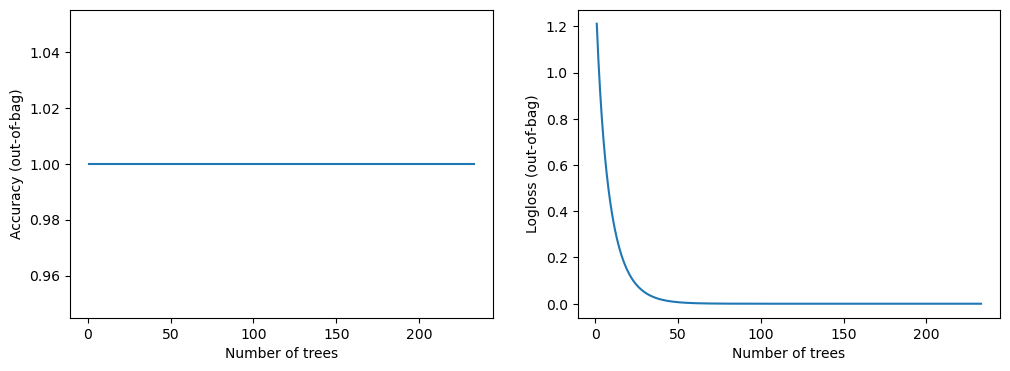


Train: 0.0000 Validation: 0.0000
##### Fold 2
Use /tmp/tmp610dmb5n as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:58:38.9659 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:58:38.9659 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:58:38.9659 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244360. Found 555 examples.
Training model...
Model trained in 0:00:00.124611
Compiling model...
Model compiled.
1/1 [==============================] - 0s 34ms/step


[INFO 23-07-21 14:58:39.3424 UTC kernel.cc:1242] Loading model from path /tmp/tmp610dmb5n/model/ with prefix 7b0a252e29564683
[INFO 23-07-21 14:58:39.3438 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 134ms/step - loss: 0.0000e+00 - binary_accuracy: 1.0000 - balanced_log_loss: 3.8743e-07


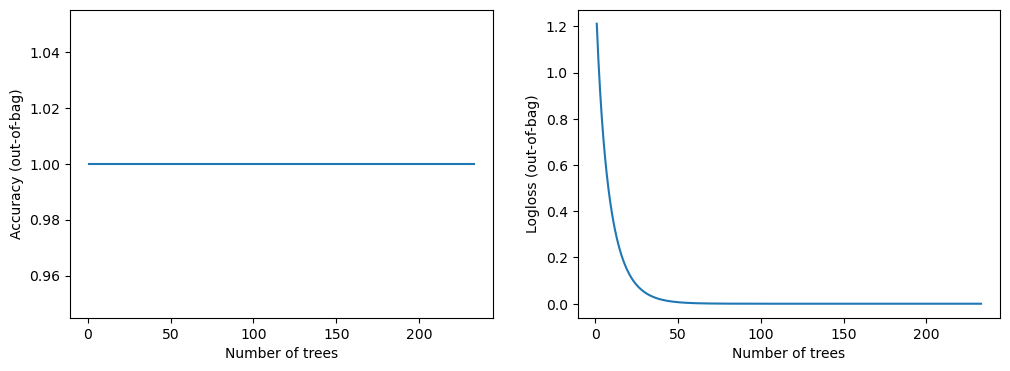


Train: 0.0000 Validation: 0.0000
##### Fold 3
Use /tmp/tmpfeequ6qa as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:58:40.4841 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:58:40.4841 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:58:40.4841 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.217339. Found 555 examples.
Training model...
Model trained in 0:00:00.101376
Compiling model...
Model compiled.
1/1 [==============================] - 0s 36ms/step


[INFO 23-07-21 14:58:40.8128 UTC kernel.cc:1242] Loading model from path /tmp/tmpfeequ6qa/model/ with prefix 097b23efe21545bf
[INFO 23-07-21 14:58:40.8143 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 133ms/step - loss: 0.0000e+00 - binary_accuracy: 1.0000 - balanced_log_loss: 3.8743e-07


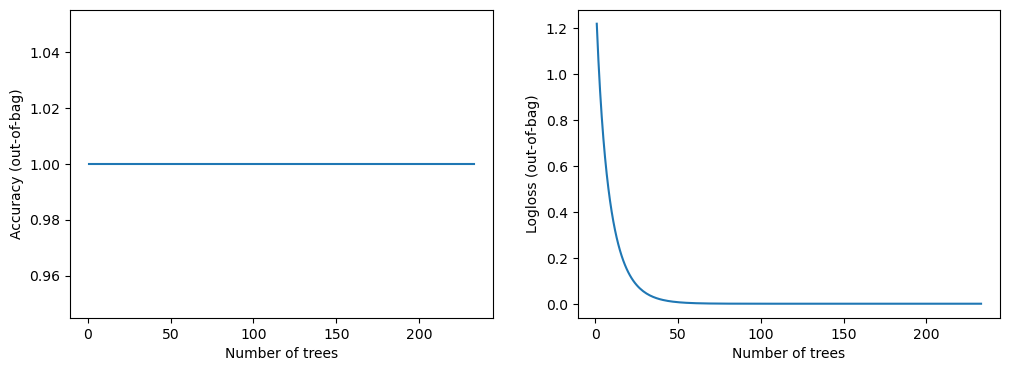


Train: 0.0000 Validation: 0.0000
##### Fold 4
Use /tmp/tmprhx1w3nq as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:58:41.9324 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:58:41.9325 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:58:41.9326 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233464. Found 555 examples.
Training model...
Model trained in 0:00:00.135377
Compiling model...
Model compiled.
1/1 [==============================] - 0s 36ms/step


[INFO 23-07-21 14:58:42.3070 UTC kernel.cc:1242] Loading model from path /tmp/tmprhx1w3nq/model/ with prefix 19ae513648f44b77
[INFO 23-07-21 14:58:42.3086 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 129ms/step - loss: 0.0000e+00 - binary_accuracy: 1.0000 - balanced_log_loss: 3.8743e-07


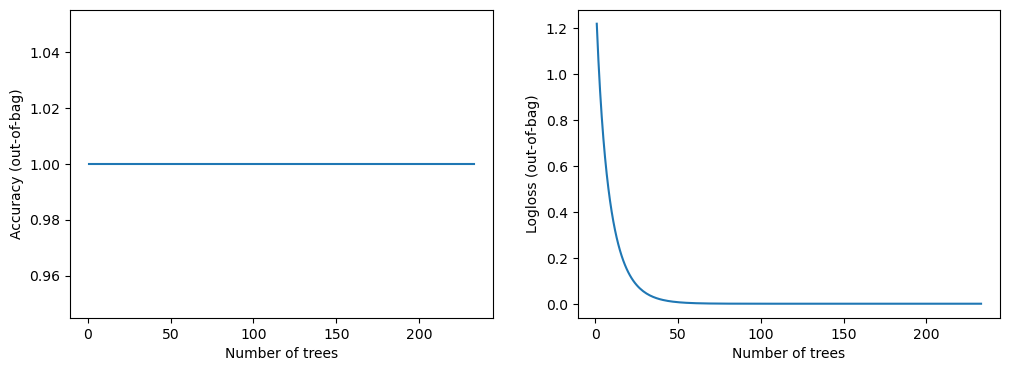


Train: 0.0000 Validation: 0.0000
##### Fold 5
Use /tmp/tmpjzsl46to as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:58:43.4626 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:58:43.4627 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:58:43.4627 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.254805. Found 555 examples.
Training model...
Model trained in 0:00:00.125307
Compiling model...
Model compiled.
1/1 [==============================] - 0s 35ms/step


[INFO 23-07-21 14:58:43.8548 UTC kernel.cc:1242] Loading model from path /tmp/tmpjzsl46to/model/ with prefix 5f6eba75888042b3
[INFO 23-07-21 14:58:43.8563 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 119ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9839 - balanced_log_loss: 0.1455


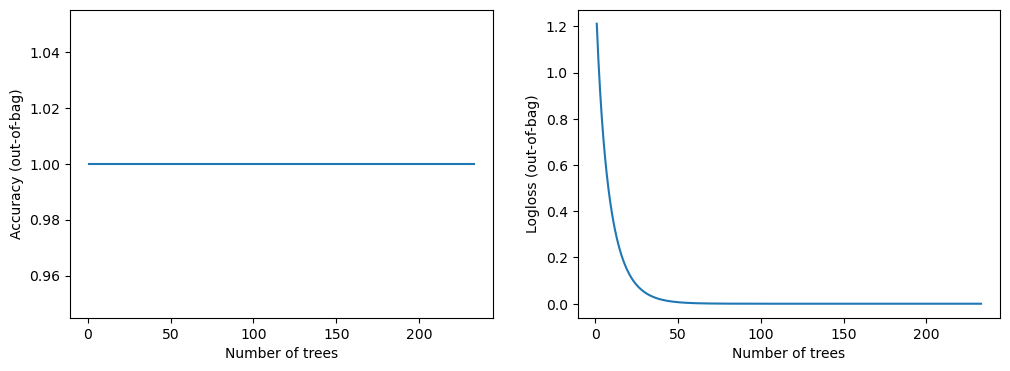


Train: 0.0000 Validation: 0.1455
##### Fold 6
Use /tmp/tmpsbcyhvlw as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:58:44.9947 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:58:44.9947 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:58:44.9947 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.209361. Found 555 examples.
Training model...
Model trained in 0:00:00.101347
Compiling model...
Model compiled.
1/1 [==============================] - 0s 33ms/step


[INFO 23-07-21 14:58:45.3137 UTC kernel.cc:1242] Loading model from path /tmp/tmpsbcyhvlw/model/ with prefix 0c99408591ae4fb4
[INFO 23-07-21 14:58:45.3152 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 118ms/step - loss: 0.0000e+00 - binary_accuracy: 1.0000 - balanced_log_loss: 3.8743e-07


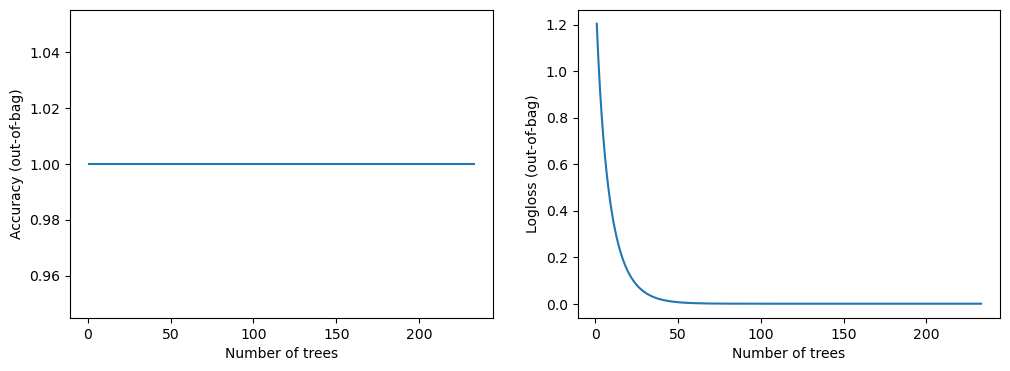


Train: 0.1455 Validation: 0.0000
##### Fold 7
Use /tmp/tmpzngivdi0 as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:58:46.4027 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:58:46.4027 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:58:46.4027 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229203. Found 555 examples.
Training model...
Model trained in 0:00:00.117713
Compiling model...
Model compiled.
1/1 [==============================] - 0s 35ms/step


[INFO 23-07-21 14:58:46.7590 UTC kernel.cc:1242] Loading model from path /tmp/tmpzngivdi0/model/ with prefix 9a7fc6bade9c4828
[INFO 23-07-21 14:58:46.7605 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 125ms/step - loss: 0.0000e+00 - binary_accuracy: 1.0000 - balanced_log_loss: 3.8743e-07


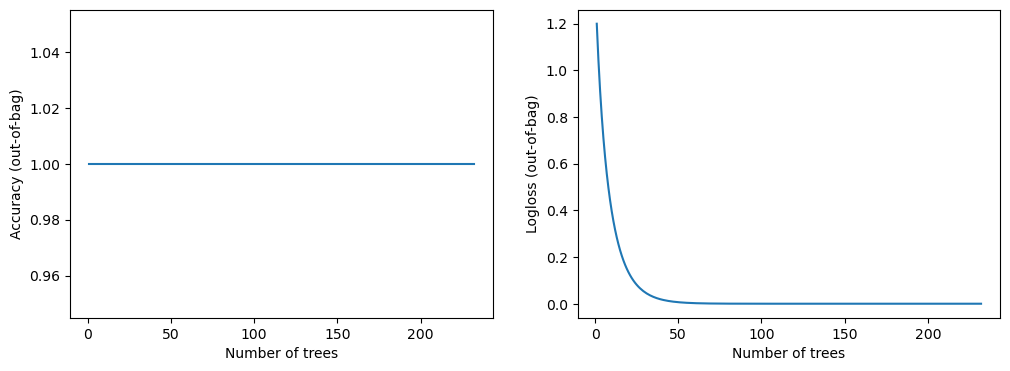


Train: 0.0000 Validation: 0.0000
##### Fold 8
Use /tmp/tmpum9_qzr_ as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:58:47.9119 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:58:47.9119 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:58:47.9119 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.235861. Found 556 examples.
Training model...
Model trained in 0:00:00.140110
Compiling model...
Model compiled.
1/1 [==============================] - 0s 39ms/step


[INFO 23-07-21 14:58:48.2943 UTC kernel.cc:1242] Loading model from path /tmp/tmpum9_qzr_/model/ with prefix 9f9802f5db314cff
[INFO 23-07-21 14:58:48.2959 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 14:58:48.2959 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 128ms/step - loss: 0.0000e+00 - binary_accuracy: 1.0000 - balanced_log_loss: 3.8743e-07


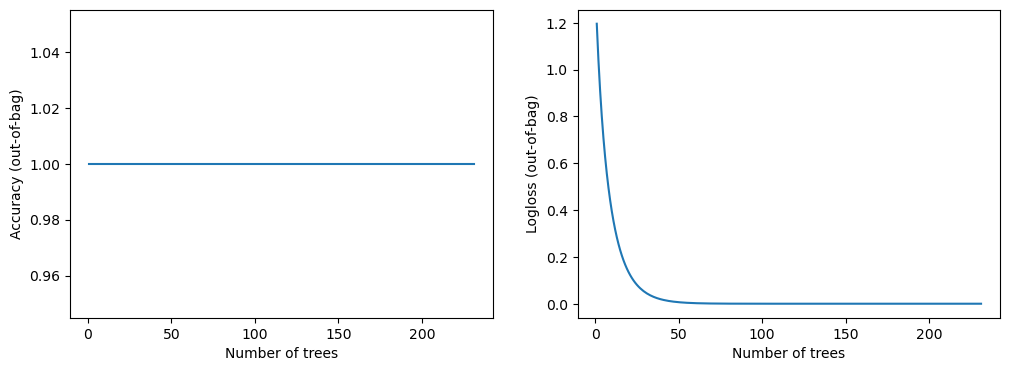


Train: 0.0000 Validation: 0.0000
##### Fold 9
Use /tmp/tmphww_d6z9 as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:58:49.4576 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:58:49.4578 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:58:49.4578 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.270843. Found 556 examples.
Training model...
Model trained in 0:00:00.117353
Compiling model...
Model compiled.


[INFO 23-07-21 14:58:49.8521 UTC kernel.cc:1242] Loading model from path /tmp/tmphww_d6z9/model/ with prefix 661420ee28c34cc0
[INFO 23-07-21 14:58:49.8537 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 128ms/step - loss: 0.0000e+00 - binary_accuracy: 1.0000 - balanced_log_loss: 3.8743e-07


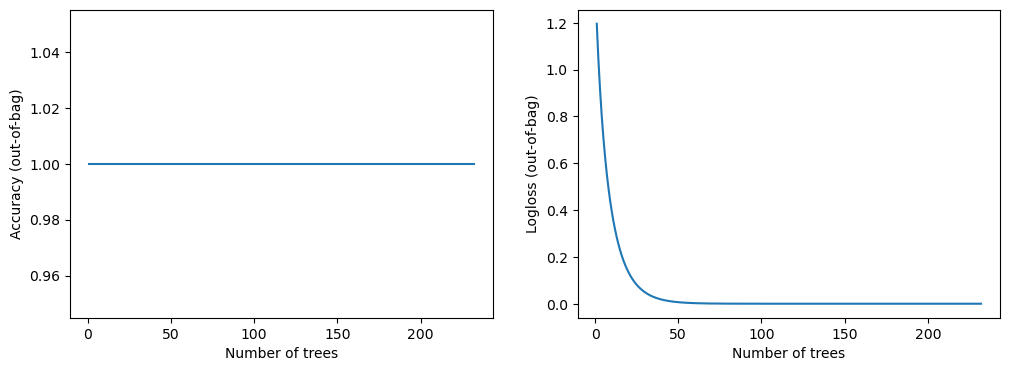


Train: 0.0000 Validation: 0.0000
##### Fold 10
Use /tmp/tmp3fnd1_vo as temporary training directory
Reading training dataset...


[WARNING 23-07-21 14:58:51.0010 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:58:51.0010 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 14:58:51.0010 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.224173. Found 556 examples.
Training model...
Model trained in 0:00:00.099639
Compiling model...
Model compiled.
1/1 [==============================] - 0s 35ms/step


[INFO 23-07-21 14:58:51.3324 UTC kernel.cc:1242] Loading model from path /tmp/tmp3fnd1_vo/model/ with prefix d52a662ea6d74680
[INFO 23-07-21 14:58:51.3340 UTC kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 0s 125ms/step - loss: 0.0000e+00 - binary_accuracy: 1.0000 - balanced_log_loss: 3.8743e-07


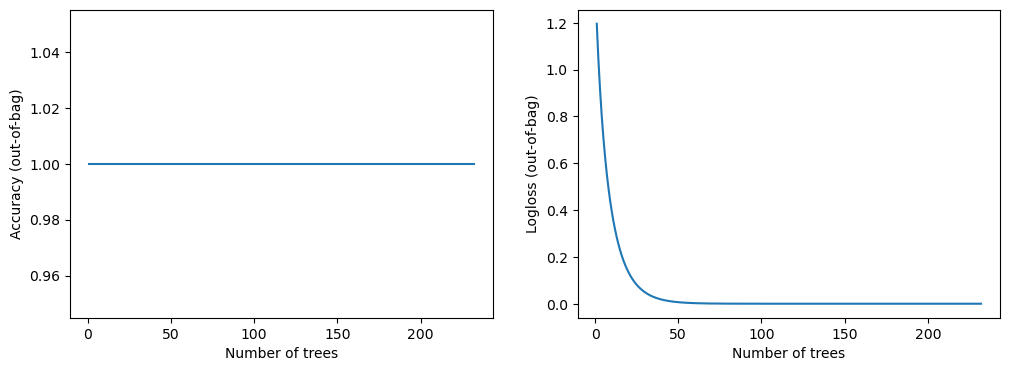


Train: 0.0000 Validation: 0.0000

Train mean: 0.0146 std: 0.0460

Validation mean: 0.0146 std: 0.0460


In [24]:
# GradientBoostedTreesModel

train_summary_gbt_3, valid_summary_gbt_3, test_summary_gbt_3, model_gbt_3,metrics_gbt_3 = train_model(
    train=train_out,test=test_out, features=['Class_RF','Class_GBT','Class_TABPFN'],                                             
    n_splits=10,                    
    model_obj=tfdf.keras.GradientBoostedTreesModel,            
    model_kwargs=dict(max_depth=2, num_trees=1000),                                                  
    model_compile_kwargs=dict(metrics=[metrics.binary_accuracy, BalancedLogLoss()]))

# Submission

In [25]:
test_summary_gbt_2

,0,1,2,3,4,5,6,7,8,9
Id,,,,,,,,,,
00eed32682bb,0.788082,0.721193,0.745136,0.571404,0.932508,0.759964,0.600483,0.699111,0.742562,0.755846
010ebe33f668,0.788082,0.721193,0.745136,0.571404,0.932508,0.759964,0.600483,0.699111,0.742562,0.755846
02fa521e1838,0.788082,0.721193,0.745136,0.571404,0.932508,0.759964,0.600483,0.699111,0.742562,0.755846
040e15f562a2,0.788082,0.721193,0.745136,0.571404,0.932508,0.759964,0.600483,0.699111,0.742562,0.755846
046e85c7cc7f,0.788082,0.721193,0.745136,0.571404,0.932508,0.759964,0.600483,0.699111,0.742562,0.755846


In [26]:
# submition_total
submition_total = test_summary_gbt_3.mean(axis=1).to_frame('class_1')
submition_total['class_0'] = 1 - submition_total['class_1']
submition_total = submition_total[['class_0','class_1']]
submition_total.to_csv('/kaggle/working/submission.csv', index=True)

In [27]:
submition_total

,class_0,class_1
Id,,
00eed32682bb,3.576279e-07,1.0
010ebe33f668,3.576279e-07,1.0
02fa521e1838,3.576279e-07,1.0
040e15f562a2,3.576279e-07,1.0
046e85c7cc7f,3.576279e-07,1.0


In [28]:
submition_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 00eed32682bb to 046e85c7cc7f
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   class_0  5 non-null      float32
 1   class_1  5 non-null      float32
dtypes: float32(2)
memory usage: 80.0+ bytes
